<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

from scipy.stats import loguniform

from skopt.space import Real

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy

In [4]:
from library.utils.ownModels.majorityClassModel import MajorityClassClassifier # Importing self-developed model object
from library.utils.ownModels.neuralNets.feedForward import FeedForwardNeuralNetwork

In [5]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [6]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/model_evaluation/results.csv"

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

## Pipeline Selection
We will having pipelines for:
- ensembled_models (random forest, gradient boosting)
- tree-based (decision trees)
- support vectors machines (non-linear*)
- naive bayes (gaussian naive bayes)
- stacking (stacking models)


* We originally conceived to add linear for the sake of model diversity. While the theory already pointed us out that the linear SVM wont be able to find the separating hyperplane (i.e., model is able to fit), we wanted to see if by setting

In [7]:
default_pipeline = ensembled_pipeline = tree_pipeline = supportVectorsMachine_pipeline = baseline_pipeline = naiveBayes_pipeline = stacking_pipeline = feedForwardNN_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        model_results_path=results_path,
                        model_task="classification")

In [8]:
pipelines = {
            "not_baseline": {
                  "ensembled": ensembled_pipeline,
                  "tree_based": tree_pipeline,
                  "support_vector_machine": supportVectorsMachine_pipeline,
                  "naive_bayes": naiveBayes_pipeline,
                  "feed_forward_neural_network": feedForwardNN_pipeline,
                  "stacking": stacking_pipeline,
                  }, 
            "baseline": {
                  "baselines": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [9]:
baseline_pipeline.dataset.example_attribute = "1"

In [10]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [11]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [12]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [13]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x282254850>, 'tree_based': <library.pipeline.pipeline.Pipeline object at 0x282254850>, 'support_vector_machine': <library.pipeline.pipeline.Pipeline object at 0x282254850>, 'naive_bayes': <library.pipeline.pipeline.Pipeline object at 0x282254850>, 'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline object at 0x282254850>, 'stacking': <library.pipeline.pipeline.Pipeline object at 0x282254850>}, 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline object at 0x282254850>, 'example': <library.pipeline.pipeline.Pipeline object at 0x2822e0f90>}}


In [14]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 10739884752. You are at automatic feature selection!


In [15]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 10773416016
Hello, world! from 10773991312


{'not_baseline': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [16]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 6424684752. You are at automatic feature selection!Whats good from 10739884752. You are at automatic feature selection!



{'not_baseline': {'ensembled': None}, 'baseline': {'example': None}}

In [17]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [18]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x282254850>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x282254850>}}

<hr>

# Start Of The Pipeline

In [19]:
default_pipeline.dataset.df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Logcat_error  \
0             8919              4786             4132  ...          1635   
1            25341             20965             4375  ...          1816   
2            24500             21378             3121  ...          2244   
3            10082              7281             2800  ...           974   
4             9077              5750             3326  ...           936   

   Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  Process_total  \
0            2351          3285            1551         11221            193   
1             826          1544            2045          8457            189   
2            3406          1565            2819         10780            195   
3            4134          3138            1556         11739            191   
4            2298          3752            1992         10488            188   

                                                Hash    Category    Family  \
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake   
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake   
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst   
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst   
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst   

   Reboot  
0  before  
1  before  
2  before  
3  before  
4  before  

[5 rows x 145 columns]

In [20]:
for col in default_pipeline.dataset.df.columns.to_list():
    print(col)

Memory_PssTotal
Memory_PssClean
Memory_SharedDirty
Memory_PrivateDirty
Memory_SharedClean
Memory_PrivateClean
Memory_SwapPssDirty
Memory_HeapSize
Memory_HeapAlloc
Memory_HeapFree
Memory_Views
Memory_ViewRootImpl
Memory_AppContexts
Memory_Activities
Memory_Assets
Memory_AssetManagers
Memory_LocalBinders
Memory_ProxyBinders
Memory_ParcelMemory
Memory_ParcelCount
Memory_DeathRecipients
Memory_OpenSSLSockets
Memory_WebViews
API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript

In [21]:
default_pipeline.dataset.df["Category"].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [22]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [23]:
default_pipeline.data_preprocessing.remove_duplicates()

No duplicates found in the dataset


In [24]:
default_pipeline.data_preprocessing.get_missing_values()

No missing values found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


In [25]:
default_pipeline.dataset.split.asses_split_classifier(p=.85,
                                                      step=.05, 
                                                      save_plots=False,
                                                      save_path=None)

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/phases/phases_implementation/dataset/split/strategies/noTimeSeries.py:114: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


train_size (%)  train_size_count  validation_size (%)  \
0            0.95           50767.0                0.025   
1            0.90           48095.0                0.050   
2            0.85           45423.0                0.075   
3            0.80           42751.0                0.100   
4            0.75           40079.0                0.125   
5            0.70           37407.0                0.150   
6            0.65           34735.0                0.175   
7            0.60           32063.0                0.200   
8            0.55           29391.0                0.225   
9            0.50           26720.0                0.250   

   validation_size_count  test_size (%)  test_size_coount  currentSE  \
0                 1336.0          0.025            1336.0   0.009769   
1                 2672.0          0.050            2672.0   0.006908   
2                 4008.0          0.075            4008.0   0.005640   
3                 5344.0          0.100            5344.0   0.004885   
4                 6680.0          0.125            6680.0   0.004369   
5                 8016.0          0.150            8016.0   0.003988   
6                 9352.0          0.175            9352.0   0.003692   
7                10688.0          0.200           10688.0   0.003454   
8                12024.0          0.225           12024.0   0.003256   
9                13360.0          0.250           13360.0   0.003089   

   differenceToPriorSE  differenceToPriorSE (%)  
0             0.009769                      inf  
1            -0.002861                -0.292893  
2            -0.001268                -0.183503  
3            -0.000756                -0.133975  
4            -0.000516                -0.105573  
5            -0.000381                -0.087129  
6            -0.000296                -0.074180  
7            -0.000238                -0.064586  
8            -0.000198                -0.057191  
9            -0.000167                -0.051317

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [26]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   save_plots=False,
                                   save_path=None)

{'Memory_PssTotal': {48143: 35115,
  10388: 71418,
  11029: 120450,
  36609: 42669,
  26413: 65679},
 'Memory_PssClean': {48143: 2936,
  10388: 11352,
  11029: 30872,
  36609: 4156,
  26413: 3256},
 'Memory_SharedDirty': {48143: 12944,
  10388: 8960,
  11029: 10704,
  36609: 12544,
  26413: 10792},
 'Memory_PrivateDirty': {48143: 25560,
  10388: 46700,
  11029: 71532,
  36609: 29872,
  26413: 52684},
 'Memory_SharedClean': {48143: 83552,
  10388: 84844,
  11029: 132144,
  36609: 91184,
  26413: 101276},
 'Memory_PrivateClean': {48143: 3072,
  10388: 11468,
  11029: 31660,
  36609: 4172,
  26413: 6004},
 'Memory_SwapPssDirty': {48143: 0, 10388: 0, 11029: 0, 36609: 0, 26413: 0},
 'Memory_HeapSize': {48143: 9086,
  10388: 15178,
  11029: 37109,
  36609: 13283,
  26413: 32054},
 'Memory_HeapAlloc': {48143: 5558,
  10388: 11581,
  11029: 30762,
  36609: 10668,
  26413: 24837},
 'Memory_HeapFree': {48143: 3527,
  10388: 3596,
  11029: 6346,
  36609: 2614,
  26413: 7216},
 'Memory_Views': {48

In [27]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

<hr>

# 3. DATA PREPROCESSING

<hr>

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [28]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="baselines")

In [29]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean      70944.886272     12764.341700        10844.857898   
std       36266.506343     12900.070827          999.033790   
min        4808.000000         0.000000         7036.000000   
25%       46185.000000      3972.000000        10540.000000   
50%       61243.000000      6356.000000        10732.000000   
75%       91785.000000     20048.000000        11144.000000   
max      819456.000000    106360.000000        40416.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean          47646.187738        88029.087694         14333.172277   
std           29793.858149        15871.265926         13468.721351   
min              12.000000         4268.000000             0.000000   
25%           31992.000000        76716.000000          4984.000000   
50%           41444.000000        89584.000000          8180.000000   
75%           55338.000000        99092.000000         21740.000000   
max          809032.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0     22278.685996      17539.452434   
std                    0.0     12570.621975      10519.885159   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13486.500000      10670.000000   
50%                    0.0     20447.000000      16560.000000   
75%                    0.0     28743.500000      22846.500000   
max                    0.0    310155.000000     286959.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean       4738.241304  ...                       466.232720   
std        2939.327428  ...                      3644.649287   
min        1012.000000  ...                         0.000000   
25%        2994.000000  ...                         0.000000   
50%        4070.000000  ...                        21.000000   
75%        5838.000000  ...                       124.500000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service    Logcat_info  Logcat_error  \
count      42751.000000     42751.000000   42751.000000  4.275100e+04   
mean           3.396201         0.723235    2337.759865  2.370012e+03   
std            1.518657         0.981457    2203.232434  1.038044e+04   
min            0.000000         0.000000       6.000000  4.000000e+01   
25%            2.000000         0.000000    1159.000000  1.098000e+03   
50%            3.000000         0.000000    2043.000000  2.020000e+03   
75%            4.000000         1.000000    3054.000000  3.028000e+03   
max           12.000000        10.000000  219143.000000  2.066046e+06   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  4.275100e+04   
mean      2296.848963   2300.166686     2300.399780  1.160519e+04   
std       2273.580562   2031.749201     1976.428885  1.101732e+04   
min         36.000000     45.000000       33.000000  3.121000e+03   
25%       1107.000000   1100.000000     1135.000000  9.422000e+03   
50%       2000.000000   2015.000000     2004.000000  1.097700e+04   
75%       3027.000000   3026.000000     3037.000000  1.299250e+04   
max     142010.000000  89456.000000   102860.000000  2.067038e+06   

       Process_total  
count   42751.000000  
mean      190.169821  
std         2.896415  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       221.000000  

[8 rows x 141 columns]

In [30]:
default_pipeline.data_preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [31]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean          0.212761         0.398628            0.186851   
std           0.795318         0.802443            1.654029   
min          -1.237610        -0.395372           -6.119205   
25%          -0.330219        -0.148296           -0.317881   
50%           0.000000         0.000000            0.000000   
75%           0.669781         0.851704            0.682119   
max          16.627478         6.220702           49.145695   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean              0.265664           -0.069490             0.367222   
std               1.276187            0.709299             0.803815   
min              -1.774694           -3.812835            -0.488183   
25%              -0.404866           -0.575080            -0.190738   
50%               0.000000            0.000000             0.000000   
75%               0.595134            0.424920             0.809262   
max              32.878780            4.201645             6.096682   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0         0.120055          0.080438   
std                    0.0         0.823925          0.863950   
min                    0.0        -1.005047         -1.093171   
25%                    0.0        -0.456217         -0.483719   
50%                    0.0         0.000000          0.000000   
75%                    0.0         0.543783          0.516281   
max                    0.0        18.988530         22.206628   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean          0.234965  ...                         3.576166   
std           1.033519  ...                        29.274291   
min          -1.075246  ...                        -0.168675   
25%          -0.378340  ...                        -0.168675   
50%           0.000000  ...                         0.000000   
75%           0.621660  ...                         0.831325   
max          29.732771  ...                       689.574297   

       Battery_wakelock  Battery_service   Logcat_info  Logcat_error  \
count      42751.000000     42751.000000  42751.000000  42751.000000   
mean           0.198101         0.723235      0.155546      0.181353   
std            0.759329         0.981457      1.162656      5.378467   
min           -1.500000         0.000000     -1.074934     -1.025907   
25%           -0.500000         0.000000     -0.466491     -0.477720   
50%            0.000000         0.000000      0.000000      0.000000   
75%            0.500000         1.000000      0.533509      0.522280   
max            4.500000        10.000000    114.564644   1069.443523   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  42751.000000   
mean         0.154609      0.148062        0.155836      0.175938   
std          1.184157      1.054906        1.039132      3.085652   
min         -1.022917     -1.022845       -1.036278     -2.200252   
25%         -0.465104     -0.475078       -0.456887     -0.435513   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.534896      0.524922        0.543113      0.564487   
max         72.921875     45.400312       53.026288    575.846800   

       Process_total  
count   42751.000000  
mean        0.042455  
std         0.724104  
min        -4.500000  
25%        -0.500000  
50%         0.000000  
75%         0.500000  
max         7.750000  

[8 rows x 141 columns]

In [32]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean          0.212761         0.398628            0.186851   
std           0.795318         0.802443            1.654029   
min          -1.237610        -0.395372           -6.119205   
25%          -0.330219        -0.148296           -0.317881   
50%           0.000000         0.000000            0.000000   
75%           0.669781         0.851704            0.682119   
max          16.627478         6.220702           49.145695   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean              0.265664           -0.069490             0.367222   
std               1.276187            0.709299             0.803815   
min              -1.774694           -3.812835            -0.488183   
25%              -0.404866           -0.575080            -0.190738   
50%               0.000000            0.000000             0.000000   
75%               0.595134            0.424920             0.809262   
max              32.878780            4.201645             6.096682   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0         0.120055          0.080438   
std                    0.0         0.823925          0.863950   
min                    0.0        -1.005047         -1.093171   
25%                    0.0        -0.456217         -0.483719   
50%                    0.0         0.000000          0.000000   
75%                    0.0         0.543783          0.516281   
max                    0.0        18.988530         22.206628   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean          0.234965  ...                         3.576166   
std           1.033519  ...                        29.274291   
min          -1.075246  ...                        -0.168675   
25%          -0.378340  ...                        -0.168675   
50%           0.000000  ...                         0.000000   
75%           0.621660  ...                         0.831325   
max          29.732771  ...                       689.574297   

       Battery_wakelock  Battery_service   Logcat_info  Logcat_error  \
count      42751.000000     42751.000000  42751.000000  42751.000000   
mean           0.198101         0.723235      0.155546      0.181353   
std            0.759329         0.981457      1.162656      5.378467   
min           -1.500000         0.000000     -1.074934     -1.025907   
25%           -0.500000         0.000000     -0.466491     -0.477720   
50%            0.000000         0.000000      0.000000      0.000000   
75%            0.500000         1.000000      0.533509      0.522280   
max            4.500000        10.000000    114.564644   1069.443523   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  42751.000000   
mean         0.154609      0.148062        0.155836      0.175938   
std          1.184157      1.054906        1.039132      3.085652   
min         -1.022917     -1.022845       -1.036278     -2.200252   
25%         -0.465104     -0.475078       -0.456887     -0.435513   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.534896      0.524922        0.543113      0.564487   
max         72.921875     45.400312       53.026288    575.846800   

       Process_total  
count   42751.000000  
mean        0.042455  
std         0.724104  
min        -4.500000  
25%        -0.500000  
50%         0.000000  
75%         0.500000  
max         7.750000  

[8 rows x 141 columns]

In [33]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean      70944.886272     12764.341700        10844.857898   
std       36266.506343     12900.070827          999.033790   
min        4808.000000         0.000000         7036.000000   
25%       46185.000000      3972.000000        10540.000000   
50%       61243.000000      6356.000000        10732.000000   
75%       91785.000000     20048.000000        11144.000000   
max      819456.000000    106360.000000        40416.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean          47646.187738        88029.087694         14333.172277   
std           29793.858149        15871.265926         13468.721351   
min              12.000000         4268.000000             0.000000   
25%           31992.000000        76716.000000          4984.000000   
50%           41444.000000        89584.000000          8180.000000   
75%           55338.000000        99092.000000         21740.000000   
max          809032.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0     22278.685996      17539.452434   
std                    0.0     12570.621975      10519.885159   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13486.500000      10670.000000   
50%                    0.0     20447.000000      16560.000000   
75%                    0.0     28743.500000      22846.500000   
max                    0.0    310155.000000     286959.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean       4738.241304  ...                       466.232720   
std        2939.327428  ...                      3644.649287   
min        1012.000000  ...                         0.000000   
25%        2994.000000  ...                         0.000000   
50%        4070.000000  ...                        21.000000   
75%        5838.000000  ...                       124.500000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service    Logcat_info  Logcat_error  \
count      42751.000000     42751.000000   42751.000000  4.275100e+04   
mean           3.396201         0.723235    2337.759865  2.370012e+03   
std            1.518657         0.981457    2203.232434  1.038044e+04   
min            0.000000         0.000000       6.000000  4.000000e+01   
25%            2.000000         0.000000    1159.000000  1.098000e+03   
50%            3.000000         0.000000    2043.000000  2.020000e+03   
75%            4.000000         1.000000    3054.000000  3.028000e+03   
max           12.000000        10.000000  219143.000000  2.066046e+06   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  4.275100e+04   
mean      2296.848963   2300.166686     2300.399780  1.160519e+04   
std       2273.580562   2031.749201     1976.428885  1.101732e+04   
min         36.000000     45.000000       33.000000  3.121000e+03   
25%       1107.000000   1100.000000     1135.000000  9.422000e+03   
50%       2000.000000   2015.000000     2004.000000  1.097700e+04   
75%       3027.000000   3026.000000     3037.000000  1.299250e+04   
max     142010.000000  89456.000000   102860.000000  2.067038e+06   

       Process_total  
count   42751.000000  
mean      190.169821  
std         2.896415  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       221.000000  

[8 rows x 141 columns]

### Outliers 

In [34]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [35]:
featuresToEncode = ["Reboot"]

In [36]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)
encoded_maps_perPipeline

Pipeline baselines in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}
Pipeline ensembled in category not_baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}


{'not_baseline': {'ensembled': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'No_Category': 3,
   'PUA': 4,
   'Ransomware': 5,
   'Riskware': 6,
   'Scareware': 7,
   'Trojan': 8,
   'Trojan_Banker': 9,
   'Trojan_Dropper': 10,
   'Trojan_SMS': 11,
   'Trojan_Spy': 12,
   'Zero_Day': 13}},
 'baseline': {'baselines': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'No_Category': 3,
   'PUA': 4,
   'Ransomware': 5,
   'Riskware': 6,
   'Scareware': 7,
   'Trojan': 8,
   'Trojan_Banker': 9,
   'Trojan_Dropper': 10,
   'Trojan_SMS': 11,
   'Trojan_Spy': 12,
   'Zero_Day': 13}}}

In [37]:
pipeline_manager.pipelines_analysis.encoded_map = encoded_maps_perPipeline["baseline"]["baselines"] # setting baseline as an arbitrary example (all are the same as for now)

Lets visualize the results of the encoding...

In [38]:
default_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
48143        -0.572982        -0.212739            3.662252   
10388         0.223136         0.310774           -2.933775   
11029         1.298399         1.525006           -0.046358   
36609        -0.407325        -0.136850            3.000000   
26413         0.097281        -0.192834            0.099338   
...                ...              ...                 ...   
42697        -0.562982        -0.382433            0.543046   
36008        -0.192939        -0.072157            2.847682   
46265        -0.526820        -0.179895            3.112583   
23587         1.155789         2.092560            0.198675   
29313         0.400395        -0.054740           -0.218543   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
48143            -0.680374           -0.269575            -0.304846   
10388             0.225135           -0.211834             0.196228   
11029             1.288786            1.902038             1.401289   
36609            -0.495674            0.071505            -0.239198   
26413             0.481453            0.522524            -0.129864   
...                    ...                 ...                  ...   
42697            -0.389446           -1.457991            -0.475531   
36008            -0.232845            0.407222            -0.058009   
46265            -0.588366           -0.299428            -0.280019   
23587             0.827551            0.464247             1.995942   
29313             1.075645            0.225778            -0.155168   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
48143                  0.0        -0.744642         -0.903544   
10388                  0.0        -0.345350         -0.408902   
11029                  0.0         1.092089          1.166345   
36609                  0.0        -0.469555         -0.483883   
26413                  0.0         0.760766          0.679752   
...                    ...              ...               ...   
42697                  0.0        -0.748509         -0.895085   
36008                  0.0        -0.160779         -0.123270   
46265                  0.0        -0.681523         -0.782819   
23587                  0.0         1.539293          1.188190   
29313                  0.0         0.471062          0.339014   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
48143        -0.190928  ...               0.0              0.0     1.229024   
10388        -0.166667  ...              -0.5              2.0    -0.712401   
11029         0.800281  ...              -0.5              1.0     0.200000   
36609        -0.511955  ...               1.0              2.0     0.147757   
26413         1.106188  ...               0.0              0.0     0.120317   
...                ...  ...               ...              ...          ...   
42697        -0.247890  ...               0.0              1.0    -0.127704   
36008        -0.399437  ...               0.0              0.0    -1.018470   
46265        -0.369198  ...               1.0              1.0     0.812137   
23587         3.105837  ...               1.0              0.0    -0.589446   
29313         1.010900  ...               2.5              1.0    -0.645383   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
48143      0.414508       -0.328646     -0.232606        1.436909   
10388     -0.995337        0.449479     -0.162513        0.420610   
11029      0.486528       -0.559896     -0.995327        0.742376   
36609     -0.969430       -0.633854     -0.031672        0.475289   
26413      2.872539       -0.715625     -0.098131       -0.980547   
...             ...             ...           ...             ...   
42697     -0.263212       -0.177083     -0.367082       -0.841220   
36008      0.315026       -0.623958      0.314642        2.321241   
46265      1.255440       -0.403646     -0.323

In [39]:
default_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

In [40]:
baseline_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
48143            35115             2936               12944   
10388            71418            11352                8960   
11029           120450            30872               10704   
36609            42669             4156               12544   
26413            65679             3256               10792   
...                ...              ...                 ...   
42697            35571              208               11060   
36008            52445             5196               12452   
46265            37220             3464               12612   
23587           113947            39996               10852   
29313            79501             5476               10600   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
48143                25560               83552                 3072   
10388                46700               84844                11468   
11029                71532              132144                31660   
36609                29872               91184                 4172   
26413                52684              101276                 6004   
...                    ...                 ...                  ...   
42697                32352               56960                  212   
36008                36008               98696                 7208   
46265                27708               82884                 3488   
23587                60764               99972                41624   
29313                66556               94636                 5580   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
48143                    0             9086              5558   
10388                    0            15178             11581   
11029                    0            37109             30762   
36609                    0            13283             10668   
26413                    0            32054             24837   
...                    ...              ...               ...   
42697                    0             9027              5661   
36008                    0            17994             15059   
46265                    0            10049              7028   
23587                    0            43932             31028   
29313                    0            27634             20688   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
48143             3527  ...                 3                0         4372   
10388             3596  ...                 2                2          693   
11029             6346  ...                 2                1         2422   
36609             2614  ...                 5                2         2323   
26413             7216  ...                 3                0         2271   
...                ...  ...               ...              ...          ...   
42697             3365  ...                 3                1         1801   
36008             2934  ...                 3                0          113   
46265             3020  ...                 5                1         3582   
23587            12903  ...                 5                0          926   
29313             6945  ...                 8                1          820   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
48143          2820            1369          1567            4737   
10388            99            2863          1702            2804   
11029          2959             925            98            3416   
36609           149             783          1954            2908   
26413          7564             626          1826             139   
...             ...             ...           ...             ...   
42697          1512            1660          1308             404   
36008          2628             802          2621            6419   
46265          4443            1225          1

In [41]:
baseline_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [42]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [43]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [44]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [45]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [46]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [47]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [48]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Support Vector Machines models
nonLinearSupportVectorModel = SVC()
linearSupportVectorModel = LinearSVC()

# Naive Bayes model
naiveBayesModel = GaussianNB()

# Neural Network model
num_features = default_pipeline.dataset.X_train.shape[1]
num_classes = default_pipeline.dataset.y_train.value_counts().shape[0]
neuralNetworkModel = FeedForwardNeuralNetwork(num_features, num_classes)

# Baseline models
logisticRegressionModel = LogisticRegression()
majorityClassModel = MajorityClassClassifier()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [49]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x282254850>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x282254850>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2842f54d0>}}

Pipelines always need to diverge from training onwards. Otherwise they will have each other results (which does not follow the isolation pattern we have programmed this with)

In [50]:
# Ensembled models
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="ensembled")

# Tree-based models
tree_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="tree_based")

# Support Vector Machines models
supportVectorsMachine_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="support_vector_machine")

# Naive Bayes model
naiveBayes_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="naive_bayes")

# Stacking model
stacking_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="stacking")

# Feed Forward Neural Network model
feedForwardNN_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="feed_forward_neural_network")

# Baseline (we leave the orignal object)

In [51]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x282362fd0>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x2843d7a90>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x2842e87d0>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x2843c1b10>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x2842d2450>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x28437c650>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2842f54d0>}}

In [52]:
# Ensembled models
ensembled_pipeline.modelling.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.modelling.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.modelling.add_model("Decision Tree", decisionTreeModel)

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.add_model("Non-linear Support Vector Machine", nonLinearSupportVectorModel) 
supportVectorsMachine_pipeline.modelling.add_model("Linear Support Vector Machine", linearSupportVectorModel) 

# Naive Bayes
naiveBayes_pipeline.modelling.add_model("Naive Bayes", naiveBayesModel)

# Stacking model (delayed till models are optimized)


# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.add_model("Feed Forward Neural Network", neuralNetworkModel, model_type="neural_network")

# Baseline
baseline_pipeline.modelling.add_model("Logistic Regression (baseline)", logisticRegressionModel)
baseline_pipeline.modelling.add_model("Majority Class (baseline)", majorityClassModel)


In [53]:
baseline_pipeline.modelling.list_of_models["Majority Class (baseline)"].tuning_states["pre"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

#### THIS WILL BE DELETED
While we debug, lets exlclude some models we dont need for now (they are very slow to train).

#### THIS WONT BE DELETED
As indicated throughout the notebook this is the part where we eliminate the models that have been excluded from the final training.

| Model | Reason for Exclusion |
|-------|----------------------|
|Linear SVM | Ran the training for 1h never converged| 

In [54]:
# Ensembled models
ensembled_pipeline.modelling.models_to_exclude = ["Gradient Boosting", "Random Forest"]

# Tree-based models
tree_pipeline.modelling.models_to_exclude = []

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.models_to_exclude = ["Linear Support Vector Machine", "Non-linear Support Vector Machine"]

# Naive Bayes models
naiveBayes_pipeline.modelling.models_to_exclude = []

# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.models_to_exclude = []

# Baseline models
baseline_pipeline.modelling.models_to_exclude = ["Logistic Regression (baseline)"]


Lets finally start fitting the models:

In [55]:
pipeline_manager.pipeline_state = "pre"

In [56]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models",
                                       verbose=False, 
                                       exclude_pipeline_names=["stacking"],
                                       current_phase=pipeline_manager.pipeline_state)

Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Skipping pipeline stacking in category not_baseline because it is in the exclude list
Gonna start fitting models in pre phase
=> Fitting Decision Tree model
=> Fitting Majority Class (baseline) model
Sklearn model: <library.utils.ownModels.majorityClassModel.MajorityClassClassifier object at 0x2896e9b10>
!> Started fitting Majority Class (baseline)
Lenght of X_data: 42751
Sklearn model: DecisionTreeClassifier()
!> Started fitting Decision Tree
Lenght of X_data: 42751
		 => Fitted Majority Class (baseline). Took 0.0013051033020019531 seconds
=> Predicting Majority Class (baseline) model
!> Started predicting Majority Class (baseline)
Training data: (42751, 142)
=> Fitting Naive Bayes model
Not training data: (5344, 142)
		 => Predicted Majority Class (baseline). Took 0.0003190040588378906 s

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/5
Not training data: (5344, 142)
		 => Predicted Naive Bayes. Took 0.349287748336792 seconds
Fitted and predicted model Naive Bayes
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4271 - loss: 15.0435 - val_accuracy: 0.6134 - val_loss: 2.6617
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6348 - loss: 2.1492 - val_accuracy: 0.6521 - val_loss: 2.0094
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.6686 - loss: 1.8810 - val_accuracy: 0.6624 - val_loss: 2.0169
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6820 - loss: 1.9241 - val_accuracy: 0.6884 - val_loss: 1.6527
Epoch 5/5
238/334 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.6935 - loss: 1.5022		 => Fitted Decision Tree. Took 2.6793529987335205 seconds
=> Predicting Decision Tree model
!> Started predicting Decision Tree
Training data: (42751, 142)
320/334 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.6949 - loss: 1.5157Not training data: (5344, 142)
		 => 

{'not_baseline': {'ensembled': None,
  'support_vector_machine': None,
  'naive_bayes': None,
  'tree_based': None,
  'feed_forward_neural_network': None},
 'baseline': {'baselines': None}}

In [57]:
dict(pipeline_manager.pipelines["not_baseline"].items())

{'ensembled': <library.pipeline.pipeline.Pipeline at 0x282362fd0>,
 'tree_based': <library.pipeline.pipeline.Pipeline at 0x2843d7a90>,
 'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x2842e87d0>,
 'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x2843c1b10>,
 'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x2842d2450>,
 'stacking': <library.pipeline.pipeline.Pipeline at 0x28437c650>}

In [58]:
estimators = []
for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      for modelName, modelObject in pipelineObject.modelling.list_of_models.items():
            if modelName in pipelineObject.modelling.models_to_exclude:
                  continue
            modelSklearn = modelObject.tuning_states["pre"].assesment["model_sklearn"]
            estimators.append((modelName, modelSklearn))

estimators

[('Decision Tree', DecisionTreeClassifier()),
 ('Naive Bayes', GaussianNB()),
 ('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                           num_classes=14, num_features=142))]

In [59]:
#Stacking model
stackingModel = StackingClassifier(
      estimators=estimators,
      final_estimator=DecisionTreeClassifier(),
      cv="prefit",
      verbose=3
)

In [60]:
stacking_pipeline.modelling.add_model("Stacking", stackingModel, model_type="stacking")

In [61]:
all_pipelines_to_exclude = []

for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      if pipelineName == "stacking":
            continue
      all_pipelines_to_exclude.append(pipelineName)

all_pipelines_to_exclude



['ensembled',
 'tree_based',
 'support_vector_machine',
 'naive_bayes',
 'feed_forward_neural_network']

In [62]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase="pre",
                                       exclude_category="baseline",
                                       exclude_pipeline_names=all_pipelines_to_exclude
                                       )

Skipping pipeline ensembled in category not_baseline because it is in the exclude list
Skipping pipeline tree_based in category not_baseline because it is in the exclude list
Skipping pipeline support_vector_machine in category not_baseline because it is in the exclude list
Skipping pipeline naive_bayes in category not_baseline because it is in the exclude list
Skipping pipeline feed_forward_neural_network in category not_baseline because it is in the exclude list
Gonna start fitting models in pre phase
=> Fitting Stacking model
Sklearn model: StackingClassifier(cv='prefit',
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Naive Bayes', GaussianNB()),
                               ('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                                                         num_classes=14,
                                 

{'not_baseline': {'stacking': None}}

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [63]:
comments = "I know cate will not like this comment"

In [64]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       verbose=False,
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

All models have been evaluated.
All models have been evaluated.
Evaluating model Naive Bayes
Evaluating Naive Bayes in pre phase
Evaluating model Decision Tree
Evaluating Decision Tree in pre phase
METRIC RESULTS FOR Naive Bayes => F1: 0.37141832537728453, Precision: 0.6136586971584927, Recall: 0.32092065868263475, Accuracy: 0.32092065868263475
METRIC RESULTS FOR Decision Tree => F1: 0.7553292313214532, Precision: 0.7545629403799476, Recall: 0.7565494011976048, Accuracy: 0.7565494011976048
Evaluating model Majority Class (baseline)
Evaluating Majority Class (baseline) in pre phase
METRIC RESULTS FOR Majority Class (baseline) => F1: 0.1110052085178755, Precision: 0.07020913263293772, Recall: 0.26497005988023953, Accuracy: 0.26497005988023953


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

Evaluating model Stacking
Evaluating Stacking in pre phase
Evaluating model Feed Forward Neural Network
Evaluating Feed Forward Neural Network in pre phase
METRIC RESULTS FOR Stacking => F1: 0.7553292313214532, Precision: 0.7545629403799476, Recall: 0.7565494011976048, Accuracy: 0.7565494011976048
METRIC RESULTS FOR Feed Forward Neural Network => F1: 0.6675369382807369, Precision: 0.6757161313897766, Recall: 0.688435628742515, Accuracy: 0.688435628742515
All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': '7b8612217cc1dc2008f3d9f891155154d3be07f4ae7820366d9310a2aa31d408', 'timeStamp': '2025-05-03 13:37:23', 'comments': 'I know cate will not like this comment', 'modelName': 'Naive Bayes', 'currentPhase': 'pre', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_Private

## Performance Evaluation 
Below are shown all the metrics we can compare our plots to:

### Cross-Model Evaluation (pre-tuning)

In [65]:
pipeline_manager.pipelines_analysis._compute_classification_report()

precision         recall       f1-score        support  \
Adware               0.782218       0.786145       0.784176          996.0   
Backdoor             0.609091       0.598214       0.603604          112.0   
FileInfector         0.714286            0.6       0.652174           25.0   
No_Category          0.396739       0.352657       0.373402          207.0   
PUA                  0.716667       0.704918       0.710744          122.0   
Ransomware           0.770308       0.774648       0.772472          355.0   
Riskware             0.847222       0.861582       0.854342         1416.0   
Scareware                0.72           0.72           0.72           75.0   
Trojan               0.810127       0.792793       0.801366          888.0   
Trojan_Banker        0.695652       0.592593           0.64           27.0   
Trojan_Dropper       0.614379       0.562874         0.5875          167.0   
Trojan_SMS            0.64878       0.671717        0.66005          198.0   
Trojan_Spy           0.794872       0.849315       0.821192          292.0   
Zero_Day             0.580169       0.592672       0.586354          464.0   
macro avg            0.692894       0.675723       0.683384         5344.0   
weighted avg         0.754563       0.756549       0.755329         5344.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy    precision       recall     f1-score  \
Adware               0.756549     0.794595      0.14759     0.248942   
Backdoor             0.756549     0.115646     0.151786     0.131274   
FileInfector         0.756549     0.018533         0.92     0.036335   
No_Category          0.756549     0.115385     0.014493     0.025751   
PUA                  0.756549     0.197605     0.270492     0.228374   
Ransomware           0.756549     0.332767     0.552113     0.415254   
Riskware             0.756549     0.754197     0.444209     0.559111   
Scareware            0.756549     0.065104     0.666667     0.118624   
Trojan               0.756549     0.845333     0.356982     0.501979   
Trojan_Banker        0.756549     0.060241      0.37037     0.103627   
Trojan_Dropper       0.756549     0.100592     0.203593     0.134653   
Trojan_SMS           0.756549      0.37931     0.222222     0.280255   
Trojan_Spy           0.756549     0.545977     0.650685      0.59375   
Zero_Day             0.756549          0.5     0.047414     0.086614   
macro avg            0.756549     0.344663     0.358473     0.247467   
weighted avg         0.756549     0.613659     0.320921     0.371418   
modelName       Decision Tree  Naive Bayes  Naive Bayes  Naive Bayes   

                    support     accuracy  ... precision    recall  f1-score  \
Adware                996.0     0.320921  ...  0.782218  0.786145  0.784176   
Backdoor              112.0     0.320921  ...  0.609091  0.598214  0.603604   
FileInfector           25.0     0.320921  ...  0.714286       0.6  0.652174   
No_Category           207.0     0.320921  ...  0.396739  0.352657  0.373402   
PUA                   122.0     0.320921  ...  0.716667  0.704918  0.710744   
Ransomware            355.0     0.320921  ...  0.770308  0.774648  0.772472   
Riskware             1416.0     0.320921  ...  0.847222  0.861582  0.854342   
Scareware              75.0     0.320921  ...      0.72      0.72      0.72   
Trojan                888.0     0.320921  ...  0.810127  0.792793  0.801366   
Trojan_Banker          27.0     0.320921  ...  0.695652  0.592593      0.64   
Trojan_Dropper        167.0     0.320921  ...  0.614379  0.562874    0.5875   
Trojan_SMS            198.0     0.320921  ...   0.64878  0.671717   0.66005   
Trojan_Spy            292.0     0.320921  ...  0.794872  0.849315  0.821192   
Zero_Day              464.0     0.320921  ...  0.580169  0.592672  0.586354   
macro avg            5344.0     0.320921  ...  0.692894  0.675723  0.683384   
weighted avg         5344.0     0.320921  ...  0.75456

In [66]:
pipeline_manager.pipelines_analysis.merged_report_per_phase["pre"]

precision         recall       f1-score        support  \
Adware               0.782218       0.786145       0.784176          996.0   
Backdoor             0.609091       0.598214       0.603604          112.0   
FileInfector         0.714286            0.6       0.652174           25.0   
No_Category          0.396739       0.352657       0.373402          207.0   
PUA                  0.716667       0.704918       0.710744          122.0   
Ransomware           0.770308       0.774648       0.772472          355.0   
Riskware             0.847222       0.861582       0.854342         1416.0   
Scareware                0.72           0.72           0.72           75.0   
Trojan               0.810127       0.792793       0.801366          888.0   
Trojan_Banker        0.695652       0.592593           0.64           27.0   
Trojan_Dropper       0.614379       0.562874         0.5875          167.0   
Trojan_SMS            0.64878       0.671717        0.66005          198.0   
Trojan_Spy           0.794872       0.849315       0.821192          292.0   
Zero_Day             0.580169       0.592672       0.586354          464.0   
macro avg            0.692894       0.675723       0.683384         5344.0   
weighted avg         0.754563       0.756549       0.755329         5344.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy    precision       recall     f1-score  \
Adware               0.756549     0.794595      0.14759     0.248942   
Backdoor             0.756549     0.115646     0.151786     0.131274   
FileInfector         0.756549     0.018533         0.92     0.036335   
No_Category          0.756549     0.115385     0.014493     0.025751   
PUA                  0.756549     0.197605     0.270492     0.228374   
Ransomware           0.756549     0.332767     0.552113     0.415254   
Riskware             0.756549     0.754197     0.444209     0.559111   
Scareware            0.756549     0.065104     0.666667     0.118624   
Trojan               0.756549     0.845333     0.356982     0.501979   
Trojan_Banker        0.756549     0.060241      0.37037     0.103627   
Trojan_Dropper       0.756549     0.100592     0.203593     0.134653   
Trojan_SMS           0.756549      0.37931     0.222222     0.280255   
Trojan_Spy           0.756549     0.545977     0.650685      0.59375   
Zero_Day             0.756549          0.5     0.047414     0.086614   
macro avg            0.756549     0.344663     0.358473     0.247467   
weighted avg         0.756549     0.613659     0.320921     0.371418   
modelName       Decision Tree  Naive Bayes  Naive Bayes  Naive Bayes   

                    support     accuracy  ... precision    recall  f1-score  \
Adware                996.0     0.320921  ...  0.782218  0.786145  0.784176   
Backdoor              112.0     0.320921  ...  0.609091  0.598214  0.603604   
FileInfector           25.0     0.320921  ...  0.714286       0.6  0.652174   
No_Category           207.0     0.320921  ...  0.396739  0.352657  0.373402   
PUA                   122.0     0.320921  ...  0.716667  0.704918  0.710744   
Ransomware            355.0     0.320921  ...  0.770308  0.774648  0.772472   
Riskware             1416.0     0.320921  ...  0.847222  0.861582  0.854342   
Scareware              75.0     0.320921  ...      0.72      0.72      0.72   
Trojan                888.0     0.320921  ...  0.810127  0.792793  0.801366   
Trojan_Banker          27.0     0.320921  ...  0.695652  0.592593      0.64   
Trojan_Dropper        167.0     0.320921  ...  0.614379  0.562874    0.5875   
Trojan_SMS            198.0     0.320921  ...   0.64878  0.671717   0.66005   
Trojan_Spy            292.0     0.320921  ...  0.794872  0.849315  0.821192   
Zero_Day              464.0     0.320921  ...  0.580169  0.592672  0.586354   
macro avg            5344.0     0.320921  ...  0.692894  0.675723  0.683384   
weighted avg         5344.0     0.320921  ...  0.75456

PLOTTING CROSS MODEL COMPARISON FOR pre PHASE
There going to be 2 rows and 2 columns
Plotting: f1-score
Plotting: recall
Plotting: precision
Plotting: accuracy


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


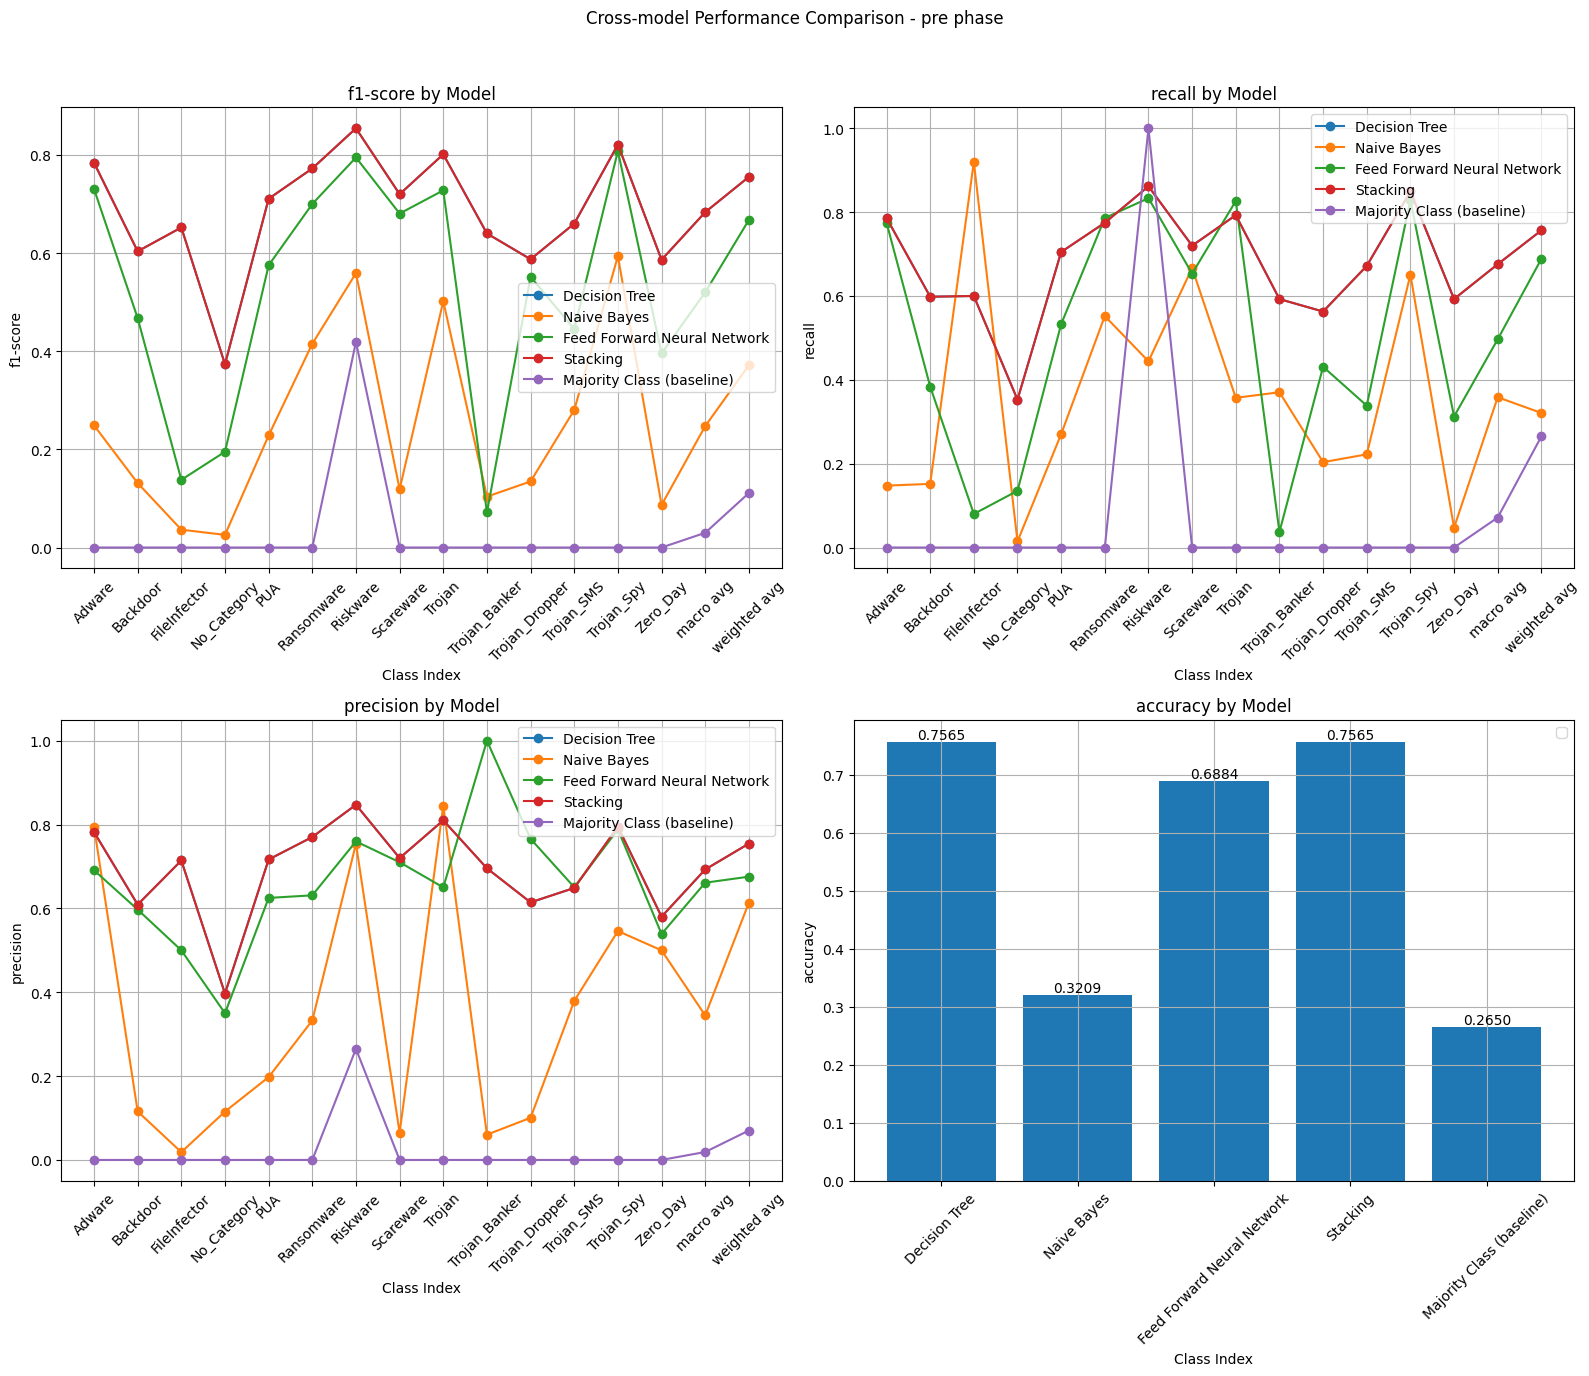

In [67]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")


Metrics df:                                                   id            timeStamp  \
0  edfc481dab4a153f3c5b05c64623b6968a92f46b02e5c1...  2025-05-03 13:37:24   

                                 comments      modelName currentPhase  \
0  I know cate will not like this comment  Decision Tree          pre   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   2.679353   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.031655                  None      0.756549             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.754563              -1    0.756549           -1      0.755329   

   f1-score_test  
0             -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


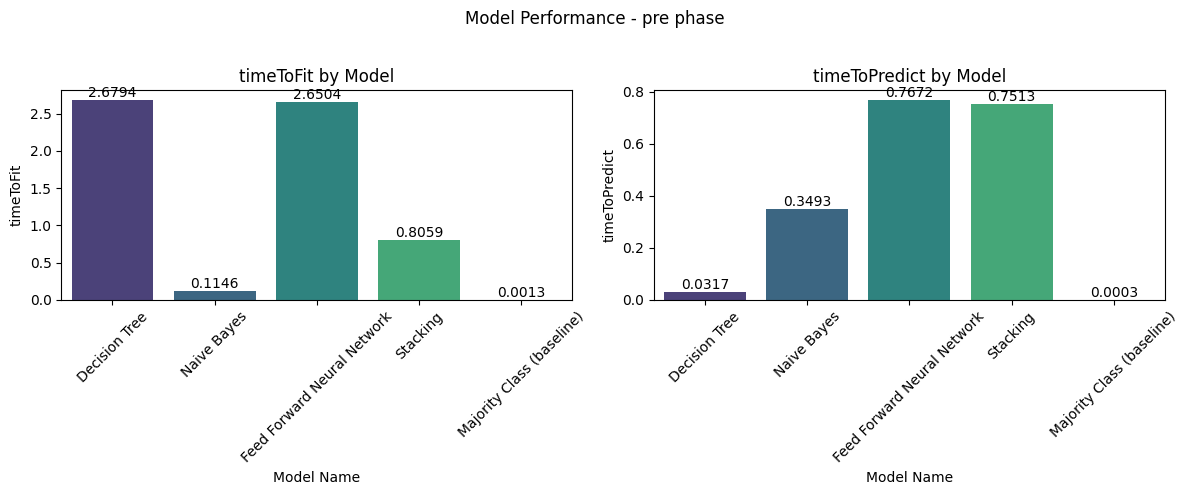

id            timeStamp  \
0  edfc481dab4a153f3c5b05c64623b6968a92f46b02e5c1...  2025-05-03 13:37:24   
0  7b8612217cc1dc2008f3d9f891155154d3be07f4ae7820...  2025-05-03 13:37:23   
0  ddd075d542e20c8de2b6db076f6fe91a082cffeddf3b20...  2025-05-03 13:37:24   
0  87f1b5338ecb57db713865295fb186fb990d4cfbd87dbc...  2025-05-03 13:37:24   
0  882c64283b0feb2722d60416f27770457df76340528664...  2025-05-03 13:37:24   

                                 comments                    modelName  \
0  I know cate will not like this comment                Decision Tree   
0  I know cate will not like this comment                  Naive Bayes   
0  I know cate will not like this comment  Feed Forward Neural Network   
0  I know cate will not like this comment                     Stacking   
0  I know cate will not like this comment    Majority Class (baseline)   

  currentPhase                                      features_used  \
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   2.679353   
0           {'priors': None, 'var_smoothing': 1e-09}   0.114571   
0  {'num_features': 142, 'num_classes': 14, 'mode...   2.650369   
0  {'cv': 'prefit', 'estimators': [('Decision Tre...   0.805915   
0                                                 {}   0.001305   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.031655                  None      0.756549             -1   
0       0.349288                  None      0.320921             -1   
0       0.767151                  None      0.688436             -1   
0       0.751337                  None      0.756549             -1   
0       0.000319                  None      0.264970             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.754563              -1    0.756549           -1      0.755329   
0       0.613659              -1    0.320921           -1      0.371418   
0       0.675716              -1    0.688436           -1      0.667537   
0       0.754563              -1    0.756549           -1      0.755329   
0       0.070209              -1    0.264970           -1      0.111005   

   f1-score_test  
0             -1  
0             -1  
0             -1  
0             -1  
0             -1

In [68]:
metrics_df = pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")
metrics_df

### Results Summary Visualization

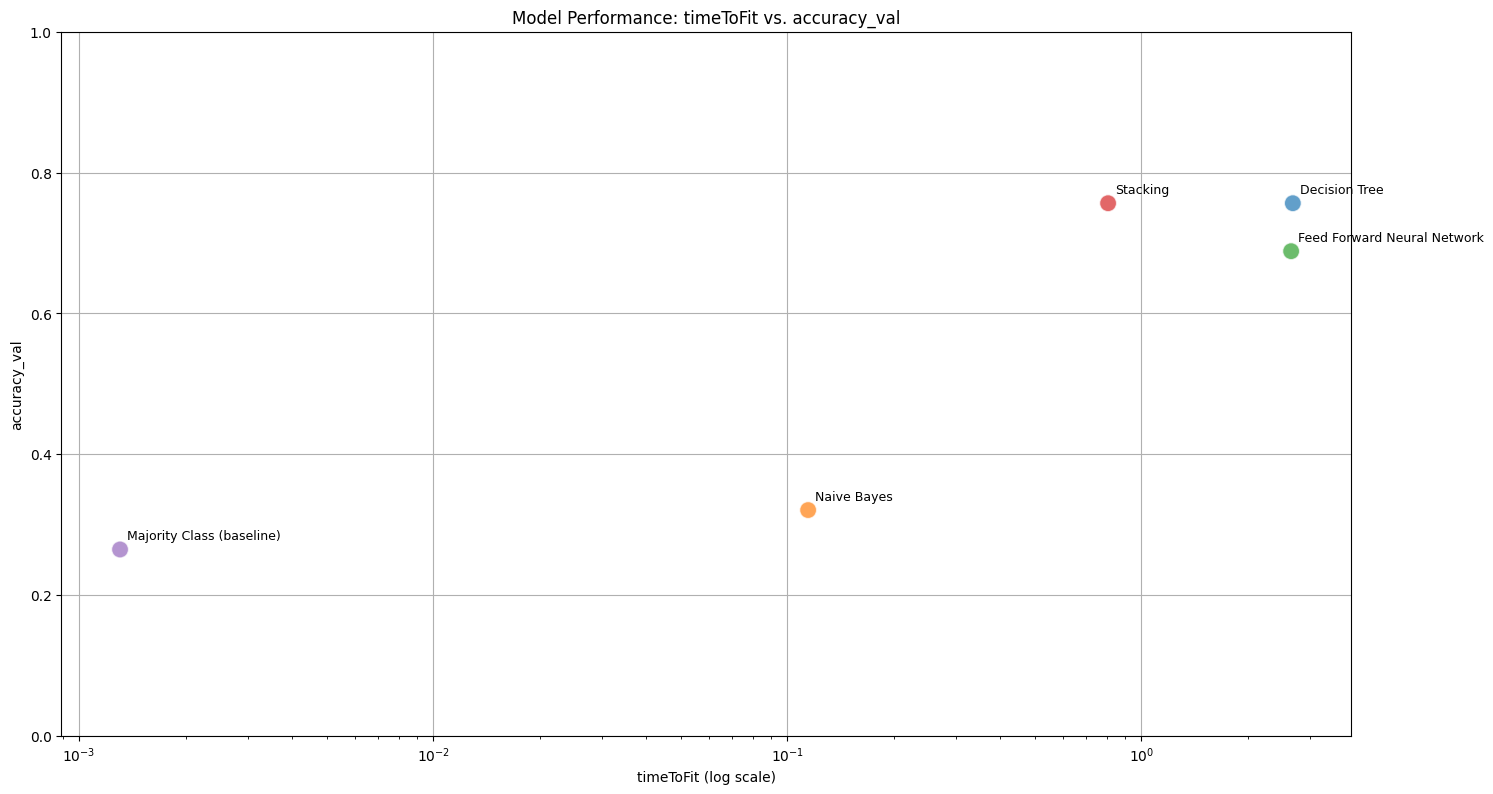

In [69]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (pre-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

There going to be 5 rows and 4 columns


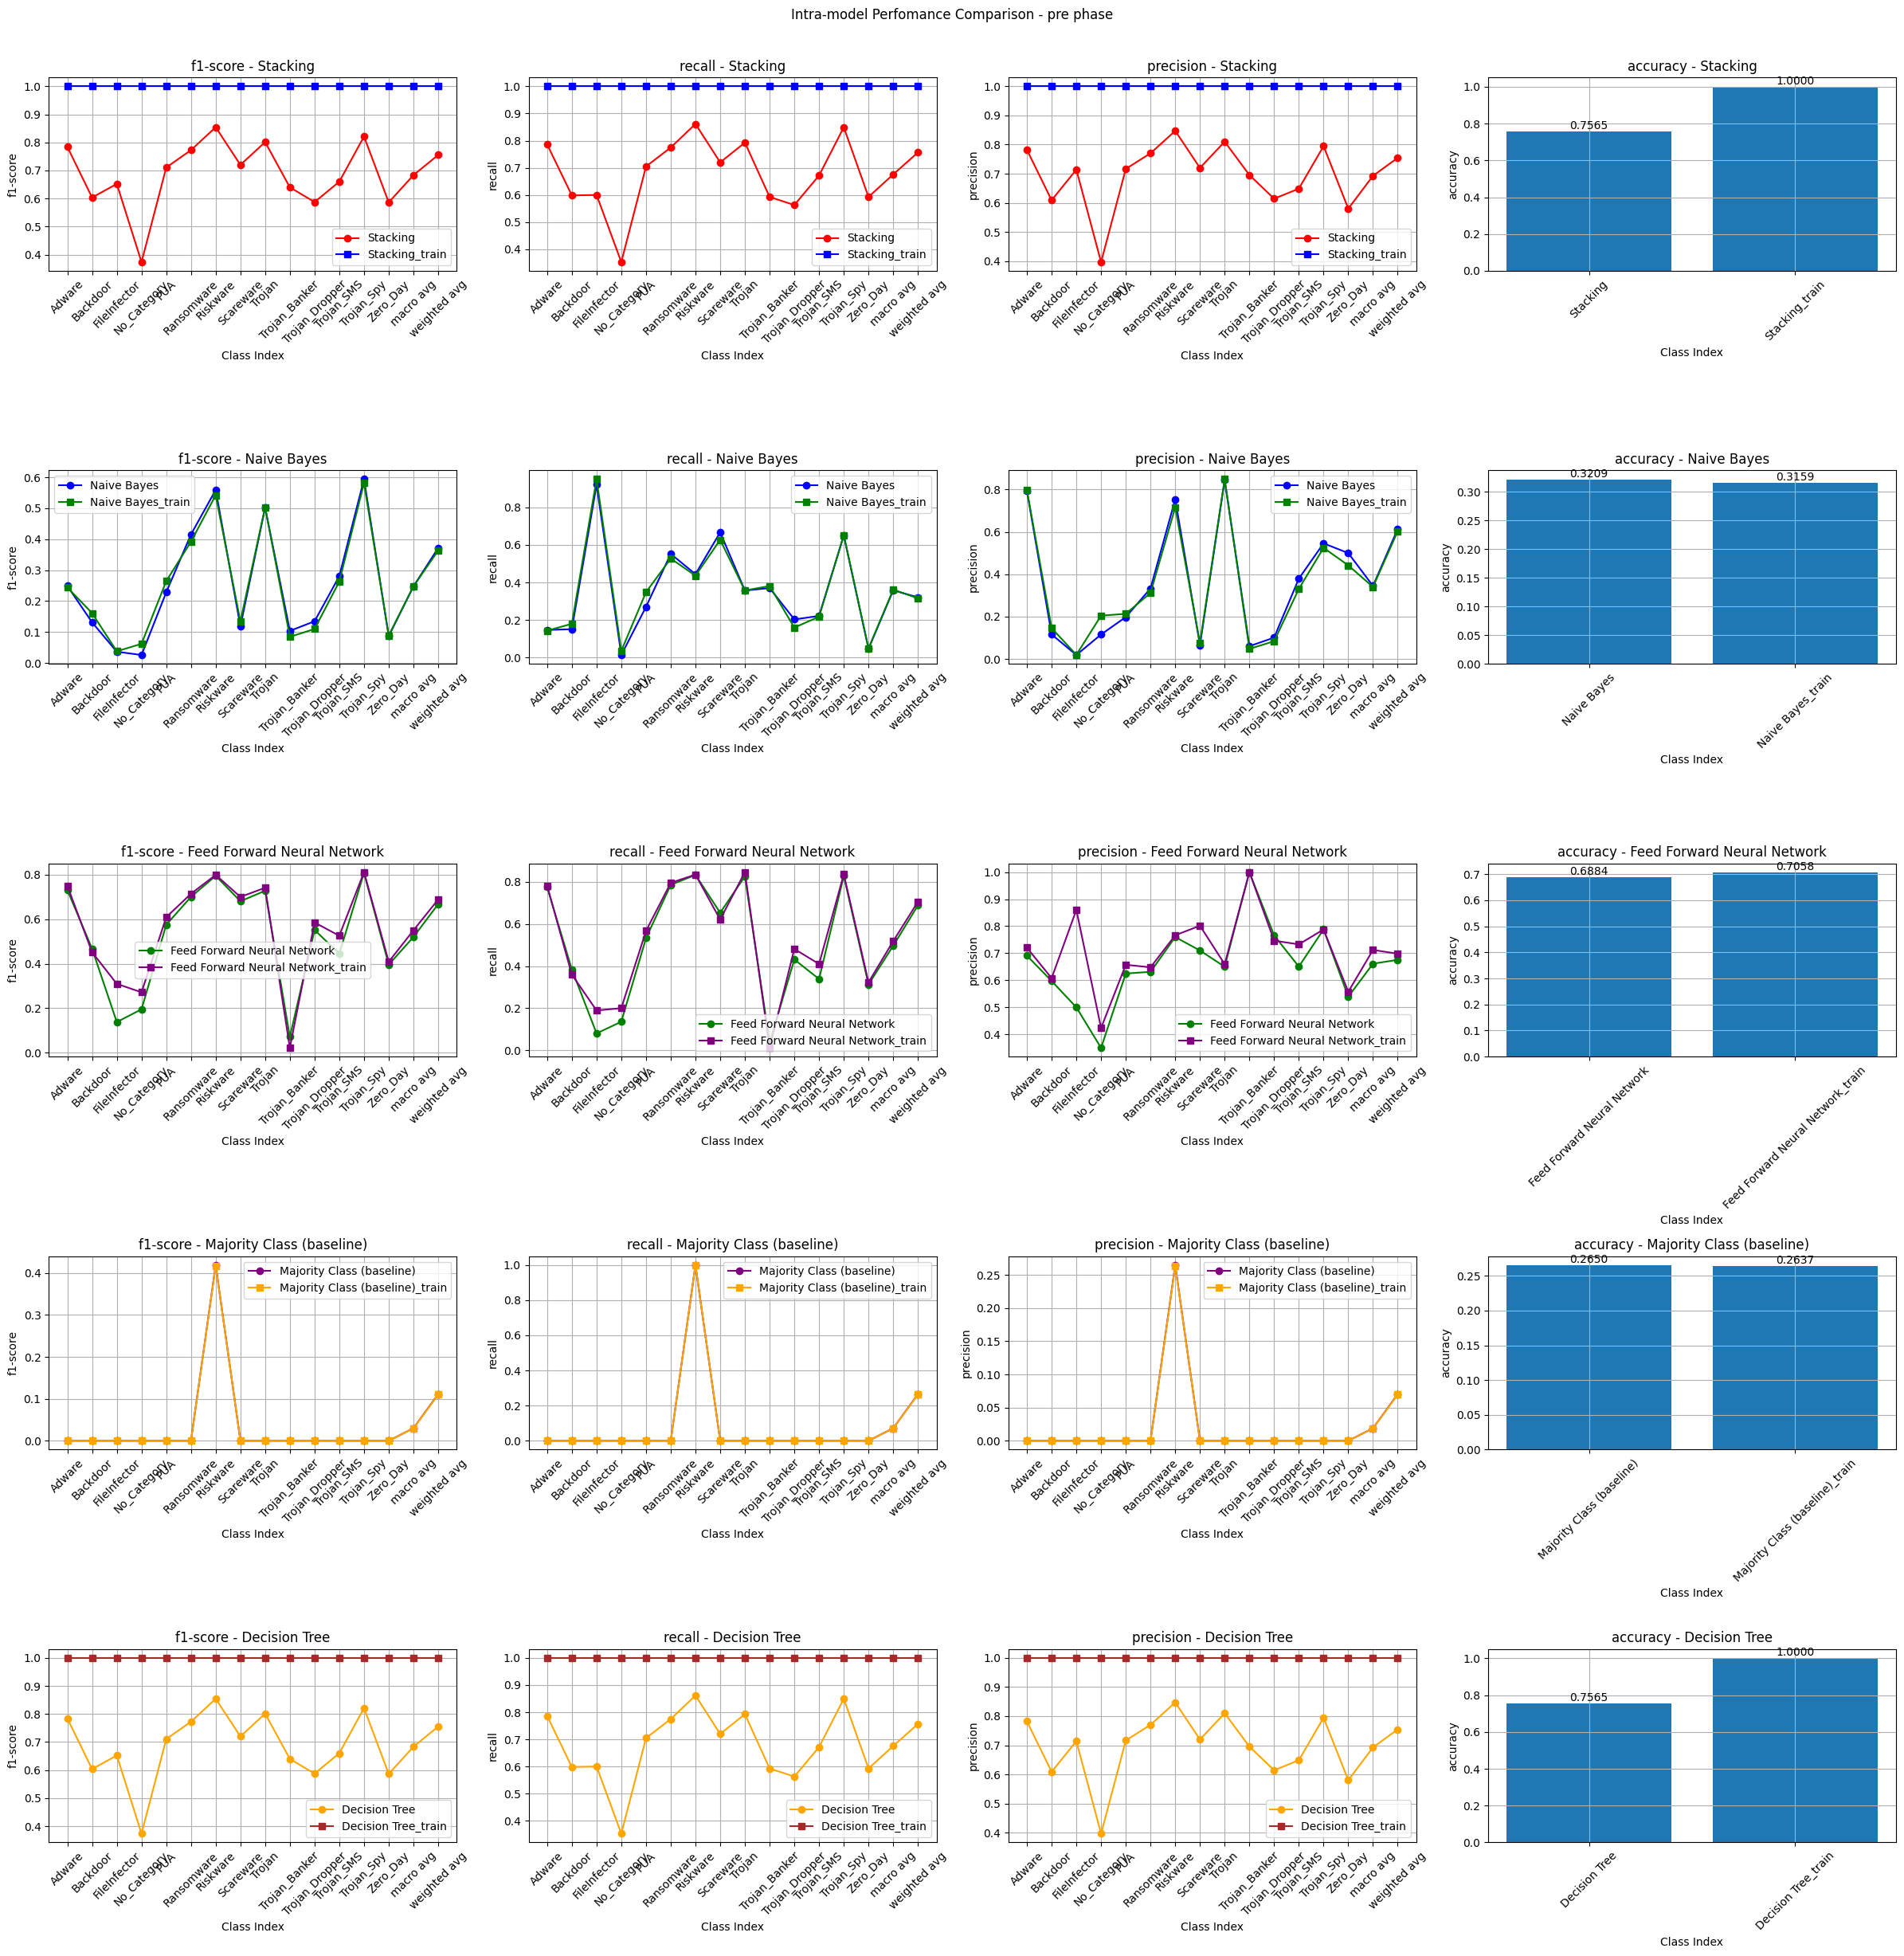

In [70]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

We can also observe the progress per epoch so lets visualize that:

In [71]:
#pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["pre"].assesment["model_sklearn"].history.history

In [72]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"], save_plots=False, save_path="")

### Residual analysis (pre-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Naive Bayes
Plotting: Feed Forward Neural Network
Plotting: Stacking
Plotting: Majority Class (baseline)


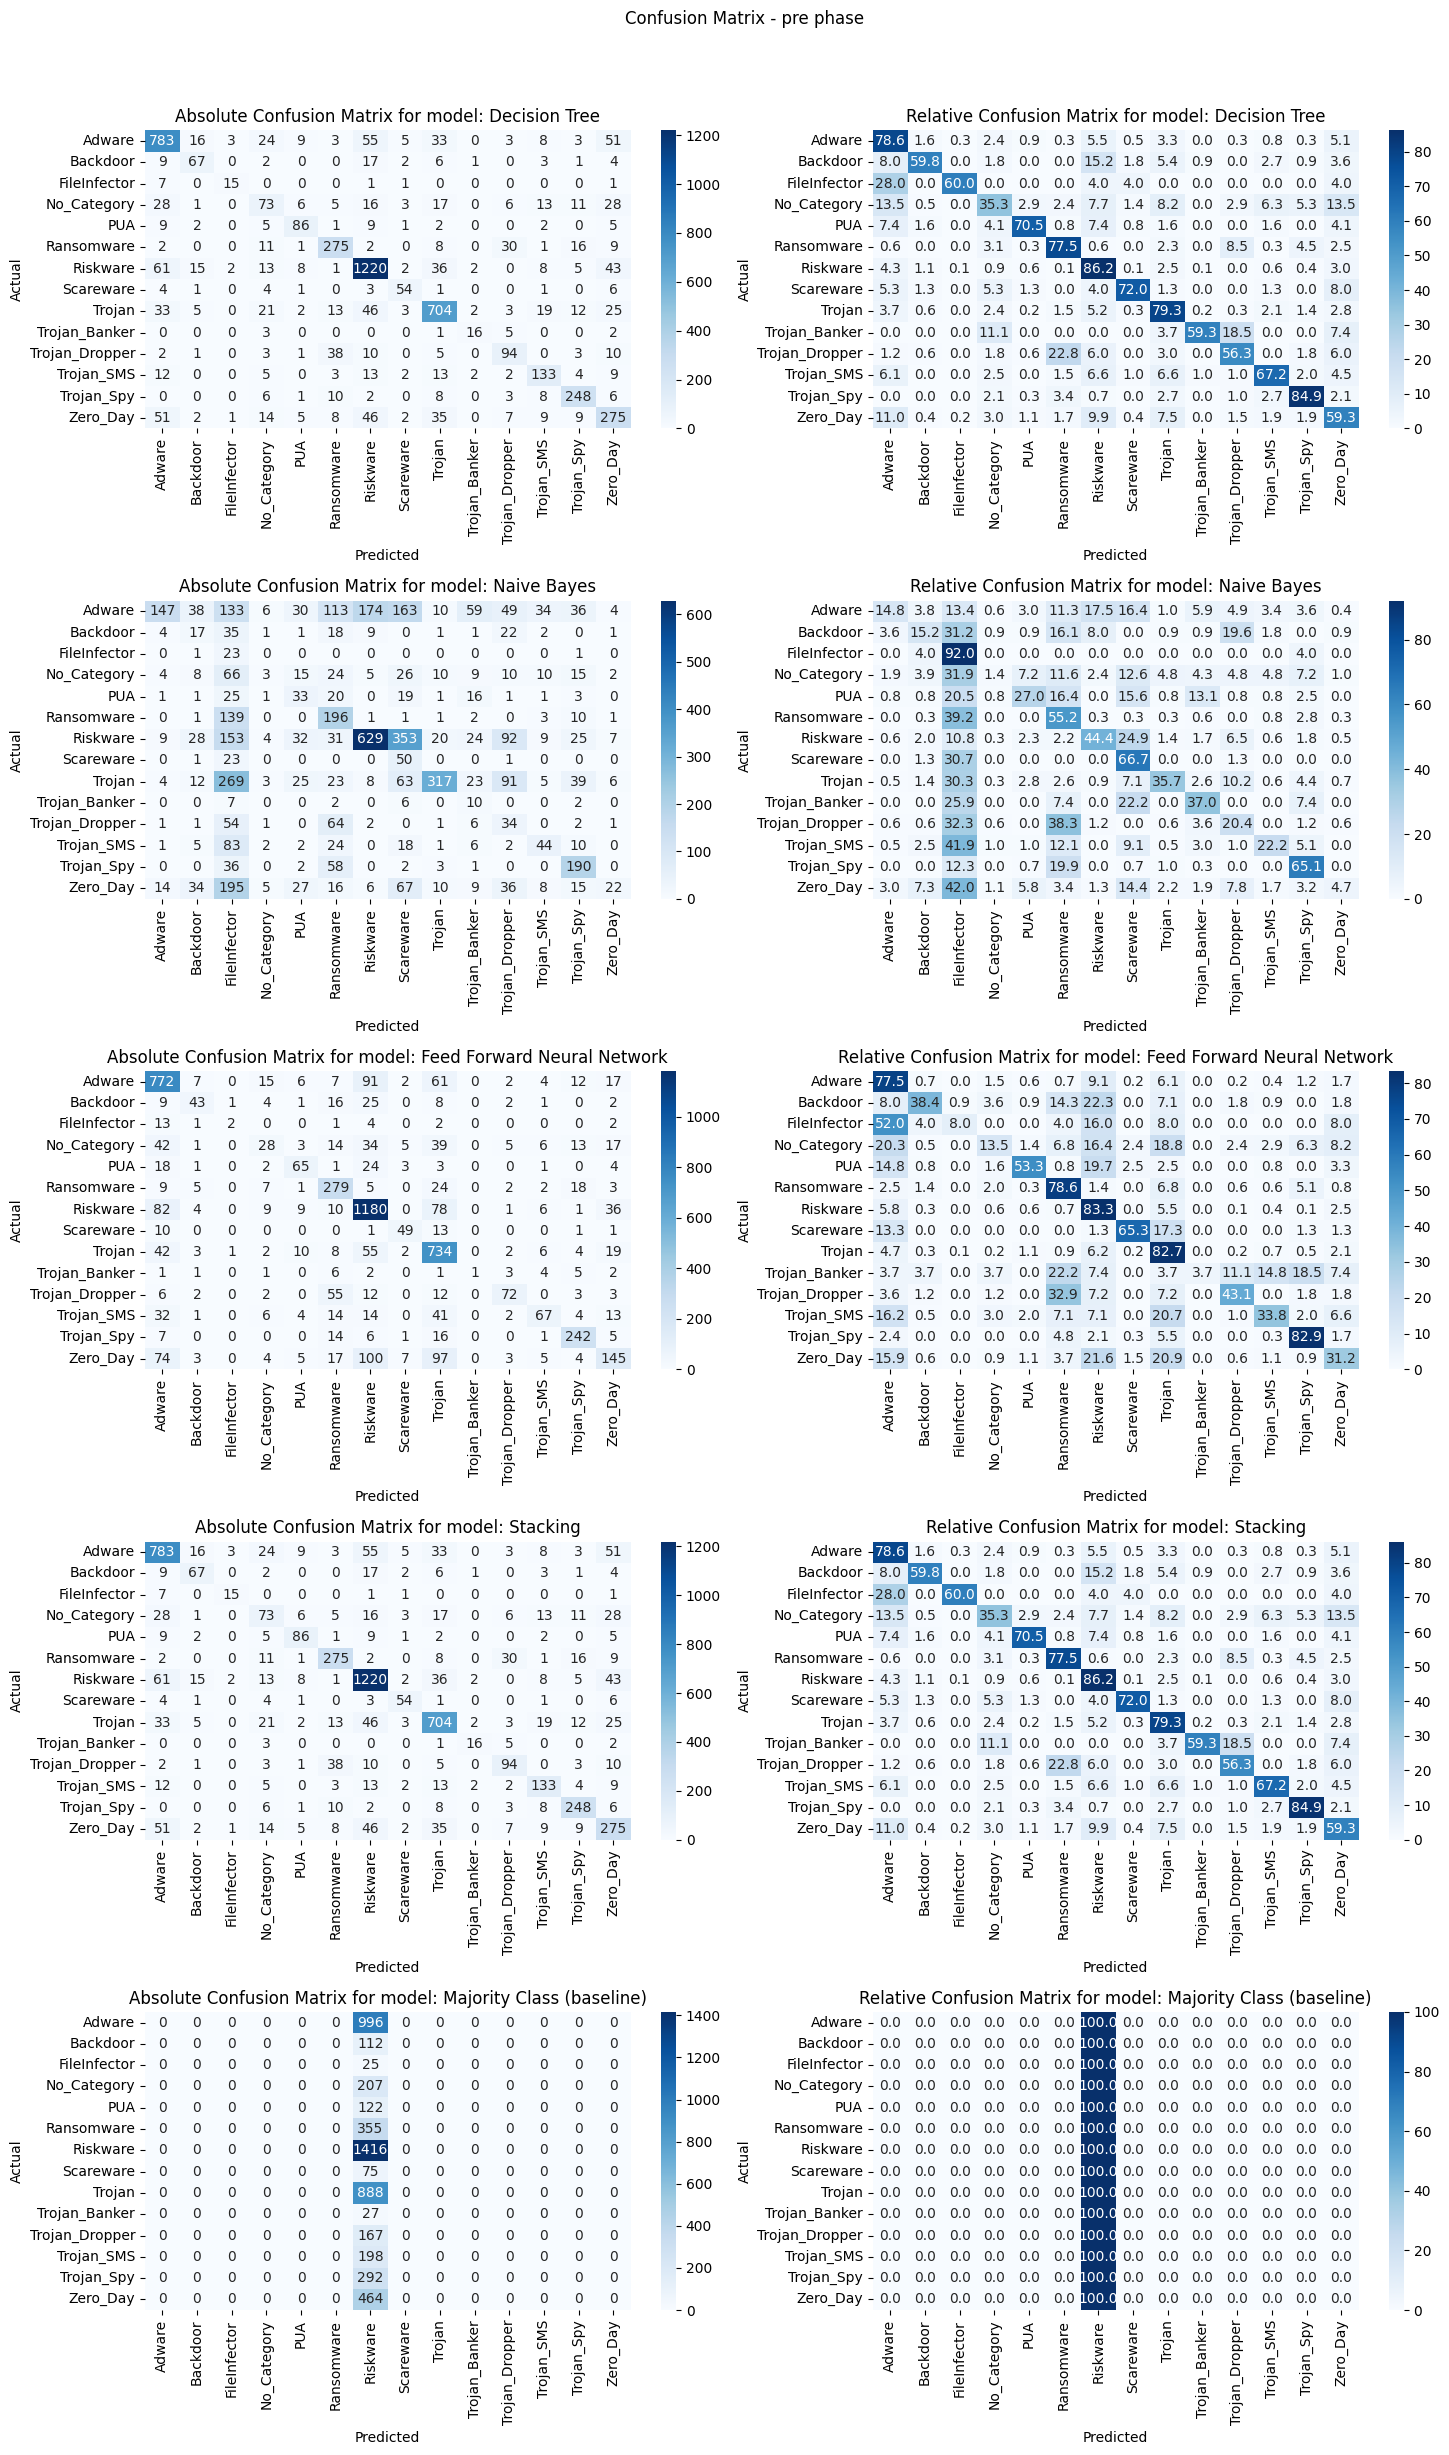

{'tree_based': 32688     8
 42208    12
 46651     8
 13497     3
 37307     6
          ..
 35718     6
 29263     8
 36945     6
 14009     5
 38099     6
 Length: 1301, dtype: int64,
 'naive_bayes': 8718     0
 5961     0
 32688    8
 46651    8
 3727     0
         ..
 19939    6
 33882    3
 20920    6
 32607    8
 38099    6
 Length: 3629, dtype: int64,
 'feed_forward_neural_network': 32688     8
 13497     3
 24902    13
 27555    13
 113      11
          ..
 19939     6
 33882     3
 20920     6
 33656     3
 38099     6
 Length: 1665, dtype: int64,
 'stacking': 32688     8
 42208    12
 46651     8
 13497     3
 37307     6
          ..
 35718     6
 29263     8
 36945     6
 14009     5
 38099     6
 Length: 1301, dtype: int64,
 'baselines': 8718      0
 5961      0
 32688     8
 42208    12
 46651     8
          ..
 43422    12
 33882     3
 33656     3
 32607     8
 8923      0
 Length: 3928, dtype: int64}

In [73]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (pre-tuning)

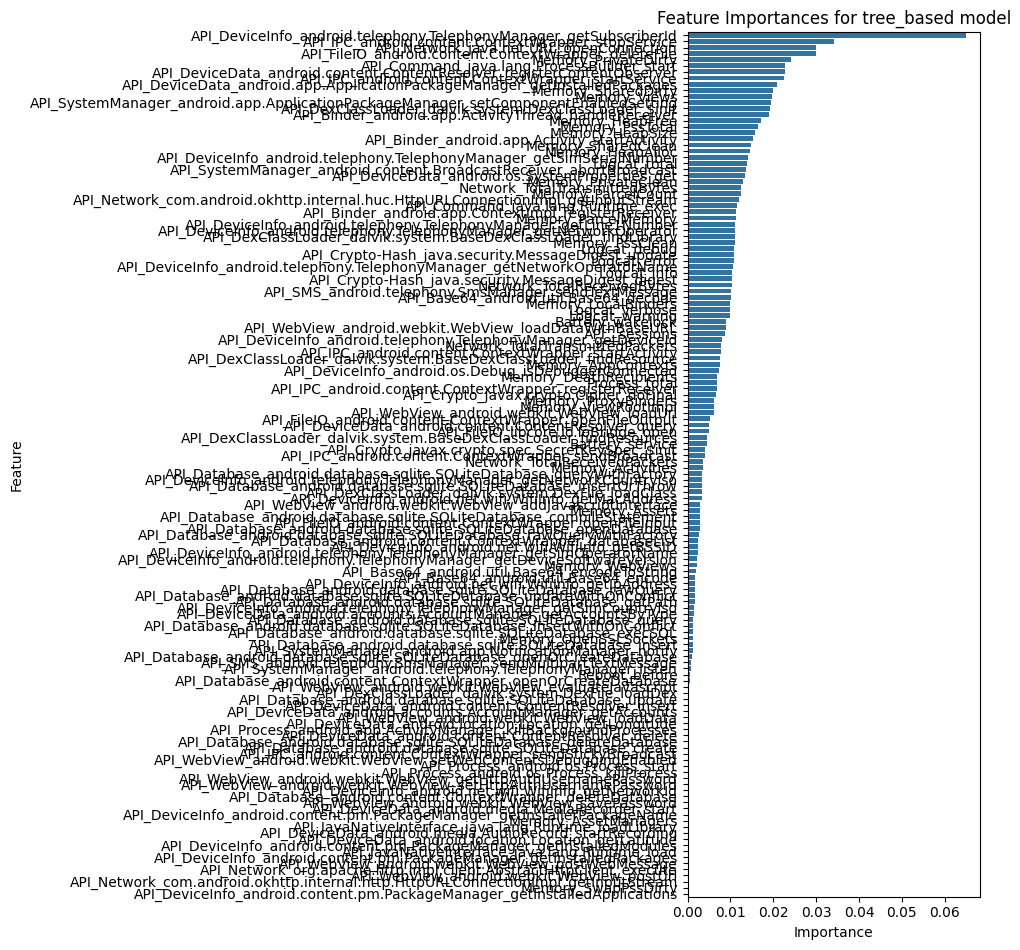

{'tree_based':                                               Feature  Importance
 78  API_DeviceInfo_android.telephony.TelephonyMana...    0.064999
 68  API_IPC_android.content.ContextWrapper_stopSer...    0.034238
 96            API_Network_java.net.URL_openConnection    0.029932
 44  API_FileIO_android.content.ContextWrapper_dele...    0.029882
 3                                 Memory_PrivateDirty    0.024088
 ..                                                ...         ...
 97  API_Network_org.apache.http.impl.client.Abstra...    0.000000
 35         API_WebView_android.webkit.WebView_postUrl    0.000000
 99  API_Network_com.android.okhttp.internal.http.H...    0.000000
 6                                 Memory_SwapPssDirty    0.000000
 93  API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 
 [142 rows x 2 columns]}

In [74]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance(save_plots=False, save_path="")
importances_dfs

## Hyperparameter Optimization
1. Bind the grids to each model in each pipeline
2. Start all optimizations in parallel

In [75]:
pipeline_manager.pipeline_state = "in"

In [76]:
rf_grid = {
      'n_estimators': [50, 100, 150, 200], 
      'max_depth': [None, 10, 20, 30], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4,]
}

dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]

} 

gnb_grid = {
    'var_smoothing': Real(1e-12, 1e-6, prior='log-uniform')
}

In [77]:
modelNameToOptimizer = {
                  "Random Forest": {
                        "optimizer_type": "bayes",
                        "param_grid": rf_grid,
                        "max_iter": 1
                  },
                  "Decision Tree": {
                        "optimizer_type": "bayes",
                        "param_grid": dt_grid,
                        "max_iter": 1
                  },
                  "Naive Bayes": {
                        "optimizer_type": "bayes",
                        "param_grid": gnb_grid,
                        "max_iter": 1
                  },
                  "Feed Forward Neural Network": {
                        "optimizer_type": "bayes_nn",
                        "param_grid": None, # its hardcoded
                        "max_iter": 2,
                        "epochs": 2 
                  }
            }

In [78]:
optimized_models = pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase=pipeline_manager.pipeline_state,
                                       modelNameToOptimizer=modelNameToOptimizer)

Trial 2 Complete [00h 00m 04s]
val_accuracy: 0.694797933101654

Best val_accuracy So Far: 0.694797933101654
Total elapsed time: 00h 00m 08s
 => FINISHED OPTIMIZATION FOR Feed Forward Neural Network
=> Predicting Feed Forward Neural Network model
!> Started predicting Feed Forward Neural Network
Predicting training data
   1/1336 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=0.563 total time=   1.6s
 507/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
Predicting not training data
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
		 => Predicted Feed Forward Neural Network. Took 0.7522602081298828 seconds
Optimized model Feed Forward Neural Network
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=0.576 total time=   1.7s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=0.589 total time=   1.6s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=0.584 total time=   1.5s
 => FINISHED OPTIMIZATION FOR Decision Tree
=> Predicting Decision Tree model
!> Started predicting Decision Tree
Predicting training data
Predicting not training data
		 => Predicted Decision Tree. Took 0.014609098434448242 seconds
Optimized model Decision Tree


Lets visualize the resutls of the optimized models

In [79]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models

{'Feed Forward Neural Network': <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier at 0x284421e50>}

In [80]:
optimized_models

{'not_baseline': {'ensembled': {},
  'support_vector_machine': {},
  'stacking': None,
  'naive_bayes': {'Naive Bayes': GaussianNB(var_smoothing=2.888176653914472e-10)},
  'feed_forward_neural_network': {'Feed Forward Neural Network': FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                            num_classes=14, num_features=142)},
  'tree_based': {'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                          min_samples_leaf=5, min_samples_split=5)}},
 'baseline': {'baselines': {}}}

If you want to see the cross validation progress for a given model you just need to:

## Stacking Model: Training and Hyperparamter Optimization

In [81]:
estimators = []

for pipelineName, results in optimized_models["not_baseline"].items():
      if isinstance(results, dict):
            for modelName, modelObject in results.items():
                  estimators.append((modelName, modelObject))

estimators

[('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)),
 ('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                           num_classes=14, num_features=142)),
 ('Decision Tree',
  DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                         min_samples_leaf=5, min_samples_split=5))]

In [82]:
#Stacking model
stackingModel = StackingClassifier(
      estimators=estimators,
      final_estimator=DecisionTreeClassifier(),
      cv="prefit",
      verbose=3
)

In [83]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"] = stackingModel
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].assesment["model_sklearn"] = stackingModel

In [84]:
all_pipelines_to_exclude = []

for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      if pipelineName == "stacking":
            continue
      all_pipelines_to_exclude.append(pipelineName)

all_pipelines_to_exclude


['ensembled',
 'tree_based',
 'support_vector_machine',
 'naive_bayes',
 'feed_forward_neural_network']

In [85]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase=pipeline_manager.pipeline_state,
                                       exclude_category="baseline",
                                       exclude_pipeline_names=all_pipelines_to_exclude
                                       )

Skipping pipeline ensembled in category not_baseline because it is in the exclude list
Skipping pipeline tree_based in category not_baseline because it is in the exclude list
Skipping pipeline support_vector_machine in category not_baseline because it is in the exclude list
Skipping pipeline naive_bayes in category not_baseline because it is in the exclude list
Skipping pipeline feed_forward_neural_network in category not_baseline because it is in the exclude list
Gonna start fitting models in in phase
=> Fitting Stacking model
Model object: None for Stacking
Sklearn model: StackingClassifier(cv='prefit',
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Naive Bayes', GaussianNB()),
                               ('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                                                         num_classes=14,
  

{'not_baseline': {'stacking': None}}

## In-tuning evaluation

In [86]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"]

StackingClassifier(cv='prefit',
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Naive Bayes', GaussianNB()),
                               ('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                                                         num_classes=14,
                                                         num_features=142))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)

In [87]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       exclude_category="baseline",
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

All models have been evaluated.
All models have been evaluated.
Evaluating model Feed Forward Neural Network
Evaluating Feed Forward Neural Network in in phase
METRIC RESULTS FOR Feed Forward Neural Network => F1: 0.6728857998814687, Precision: 0.6910344404156286, Recall: 0.6947979041916168, Accuracy: 0.6947979041916168
All models have been evaluated.
Evaluating model Decision Tree
Evaluating Decision Tree in in phase
Evaluating model Naive Bayes
Evaluating Naive Bayes in in phase
METRIC RESULTS FOR Naive Bayes => F1: 0.3673689793625029, Precision: 0.6182036105214448, Recall: 0.3166167664670659, Accuracy: 0.3166167664670659
METRIC RESULTS FOR Decision Tree => F1: 0.5624691572853183, Precision: 0.5672190264040294, Recall: 0.5800898203592815, Accuracy: 0.5800898203592815
Evaluating model Stacking
Evaluating Stacking in in phase
METRIC RESULTS FOR Stacking => F1: 0.7553292313214532, Precision: 0.7545629403799476, Recall: 0.7565494011976048, Accuracy: 0.7565494011976048


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': 'e06dc18f115be574c0d7150125140b1583629b860275206f81df475ceebad8ec', 'timeStamp': '2025-05-03 13:37:54', 'comments': 'I know cate will not like this comment', 'modelName': 'Naive Bayes', 'currentPhase': 'in', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBa

### Cross-Model Evaluation (in-tuning)

In [88]:
pipeline_manager.pipelines_analysis._compute_classification_report().T

Adware  Backdoor FileInfector No_Category       PUA Ransomware  \
precision  0.495665  0.215116          0.0         0.0     0.456   0.546218   
recall     0.688755  0.330357          0.0         0.0  0.467213   0.732394   
f1-score   0.576471  0.260563          0.0         0.0  0.461538   0.625752   
support       996.0     112.0         25.0       207.0     122.0      355.0   
accuracy    0.58009   0.58009      0.58009     0.58009   0.58009    0.58009   
precision  0.801136  0.108974     0.018254    0.115385  0.178378   0.327869   
recall     0.141566  0.151786         0.92    0.014493  0.270492    0.56338   
f1-score   0.240614  0.126866     0.035798    0.025751  0.214984   0.414508   
support       996.0     112.0         25.0       207.0     122.0      355.0   
accuracy   0.316617  0.316617     0.316617    0.316617  0.316617   0.316617   
precision  0.605803   0.68254          1.0    0.428571  0.560976   0.724138   
recall     0.859438  0.383929         0.08    0.101449  0.188525   0.769014   
f1-score   0.710668  0.491429     0.148148    0.164062  0.282209   0.745902   
support       996.0     112.0         25.0       207.0     122.0      355.0   
accuracy   0.694798  0.694798     0.694798    0.694798  0.694798   0.694798   
precision  0.782218  0.609091     0.714286    0.396739  0.716667   0.770308   
recall     0.786145  0.598214          0.6    0.352657  0.704918   0.774648   
f1-score   0.784176  0.603604     0.652174    0.373402  0.710744   0.772472   
support       996.0     112.0         25.0       207.0     122.0      355.0   
accuracy   0.756549  0.756549     0.756549    0.756549  0.756549   0.756549   

           Riskware Scareware    Trojan Trojan_Banker Trojan_Dropper  \
precision  0.717077      0.55  0.622967           0.0       0.633803   
recall     0.699859  0.586667  0.690315           0.0       0.269461   
f1-score   0.708363  0.567742  0.654915           0.0       0.378151   
support      1416.0      75.0     888.0          27.0          167.0   
accuracy    0.58009   0.58009   0.58009       0.58009        0.58009   
precision  0.751508  0.065445  0.878116      0.064103       0.101493   
recall     0.439972  0.666667  0.356982       0.37037       0.203593   
f1-score   0.555011   0.11919  0.507606       0.10929       0.135458   
support      1416.0      75.0     888.0          27.0          167.0   
accuracy   0.316617  0.316617  0.316617      0.316617       0.316617   
precision  0.756654  0.695652  0.758811      0.769231       0.855422   
recall      0.84322      0.64  0.775901       0.37037        0.42515   
f1-score   0.797595  0.666667  0.767261           0.5          0.568   
support      1416.0      75.0     888.0          27.0          167.0   
accuracy   0.694798  0.694798  0.694798      0.694798       0.694798   
precision  0.847222      0.72  0.810127      0.695652       0.614379   
recall     0.861582      0.72  0.792793      0.592593       0.562874   
f1-score   0.854342      0.72  0.801366          0.64         0.5875   
support      1416.0      75.0     888.0          27.0          167.0   
accuracy   0.756549  0.756549  0.756549      0.756549       0.756549   

          Trojan_SMS Trojan_Spy  Zero_Day macro avg weighted avg  \
precision   0.272727   0.898058       0.5  0.421974     0.567219   
recall       0.30303   0.633562  0.262931   0.40461      0.58009   
f1-score    0.287081   0.742972  0.344633  0.400584     0.562469   
support        198.0      292.0     464.0    5344.0       5344.0   
accuracy     0.58009    0.58009   0.58009   0.58009      0.58009   
precision   0.376068   0.537994       0.5  0.344623     0.618204   
recall      0.222222   0.606164  0.043103  0.355056     0.316617   
f1-score    0.279365   0.570048  0.079365  0.243847     0.367369   
support        198.0      292.0     464.0    5344.0       5344.0   
accuracy    0.316617   0.316617  0.316617  0.316617     0.316617   
precision   0.820225   0.795455  0.470085  0.708826     0.691034   
recall      0.368687   0

PLOTTING CROSS MODEL COMPARISON FOR in PHASE
There going to be 2 rows and 2 columns
Plotting: f1-score
Plotting: recall
Plotting: precision
Plotting: accuracy


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


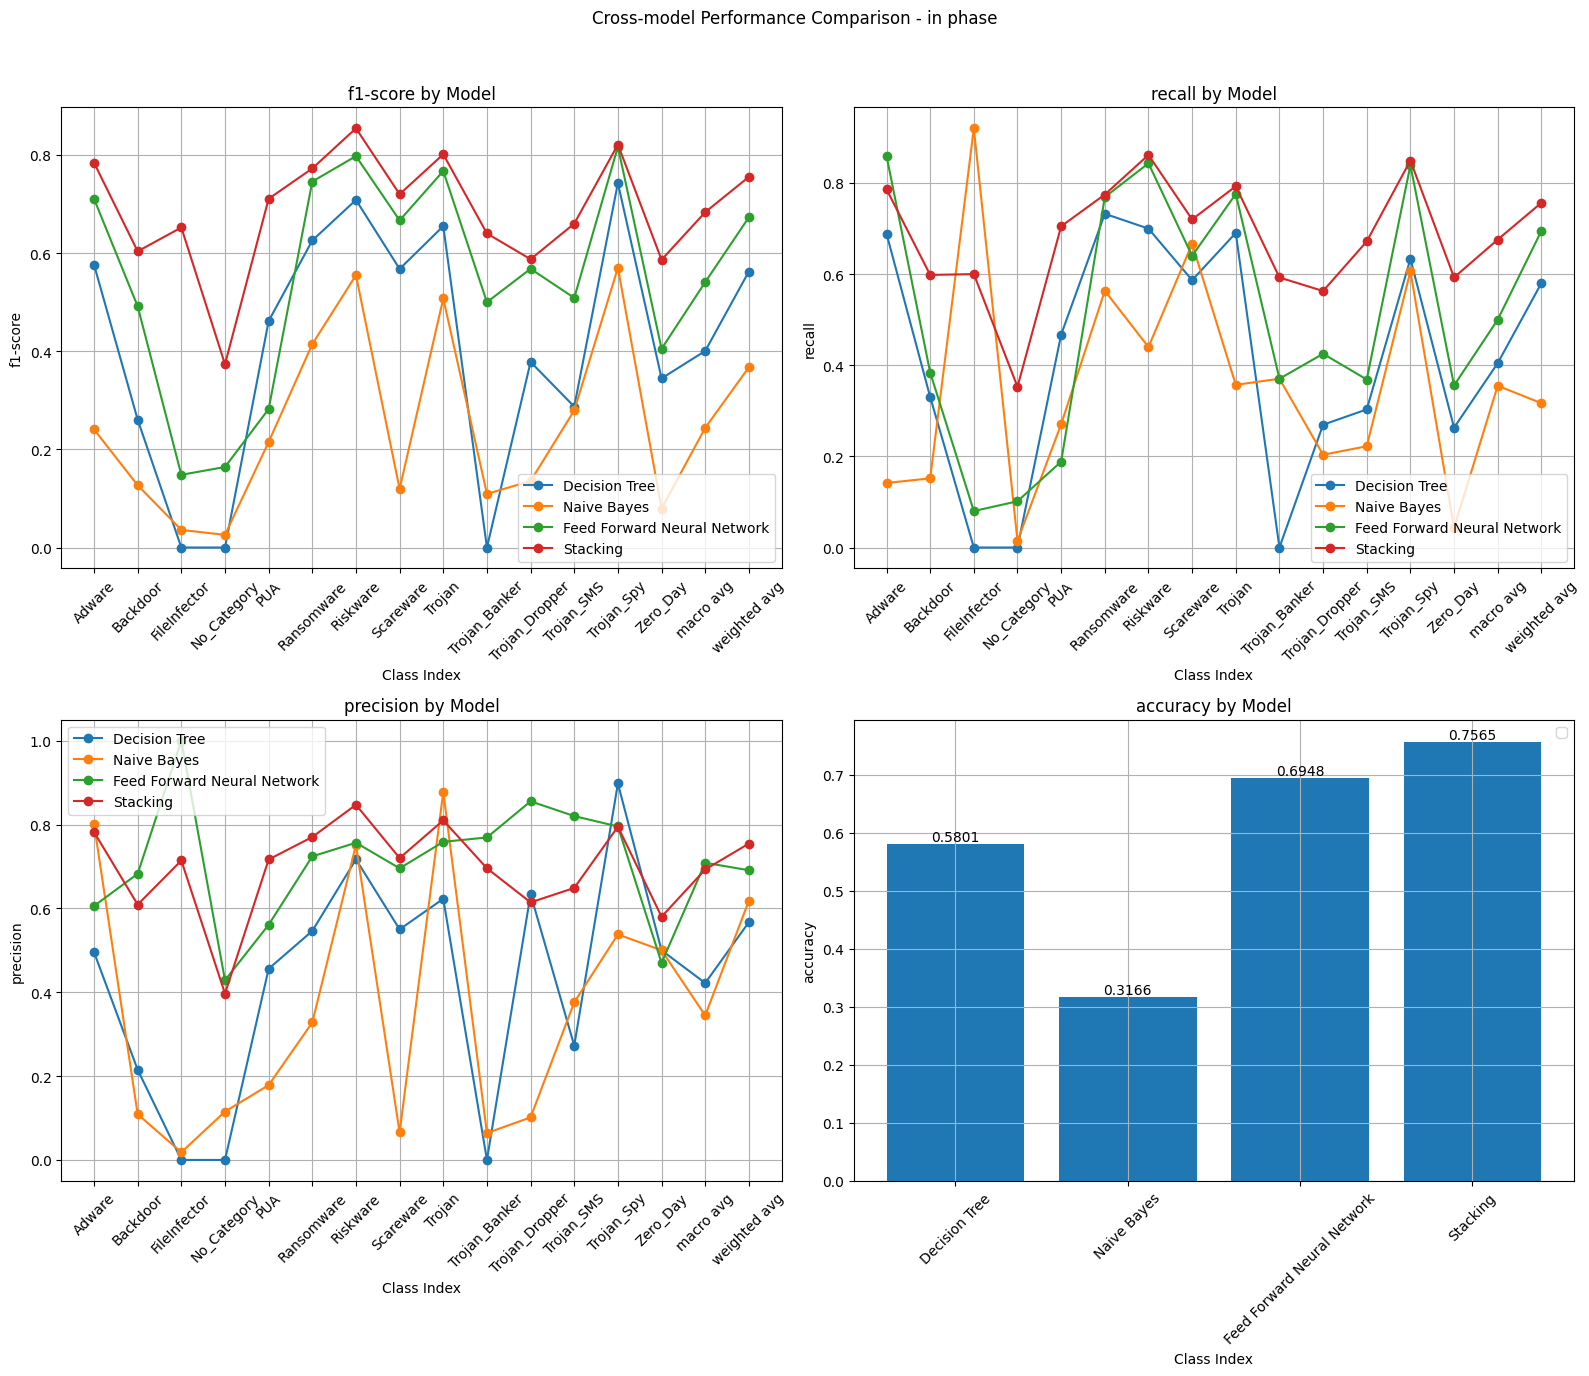

In [89]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  d376dd27b2c203d14941129df56325a29a77bb8c3520e8...  2025-05-03 13:37:54   

                                 comments      modelName currentPhase  \
0  I know cate will not like this comment  Decision Tree           in   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...  10.318611   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.014609                  None       0.58009             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.567219              -1     0.58009           -1      0.562469   

   f1-score_test  
0             -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


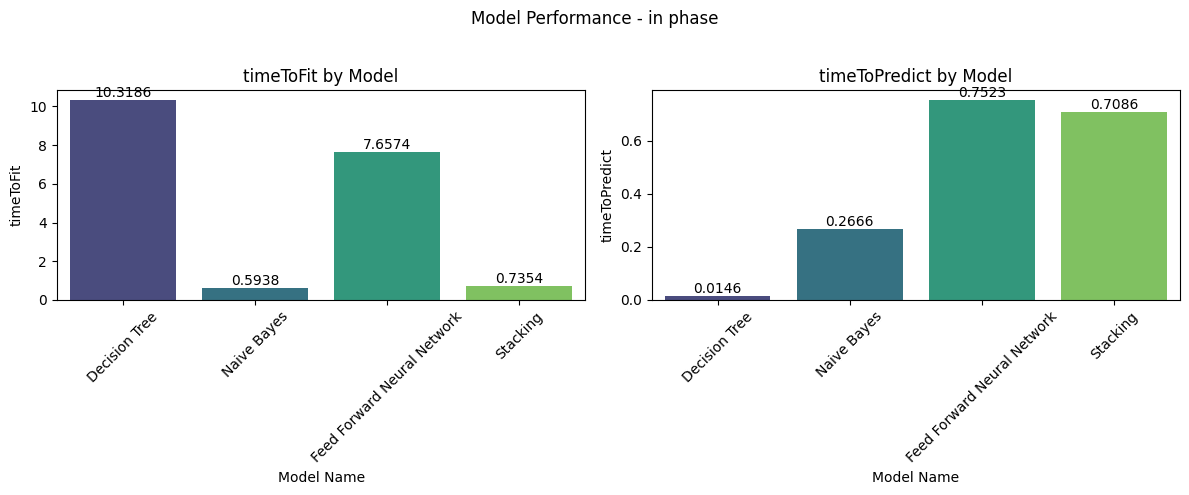

id            timeStamp  \
0  d376dd27b2c203d14941129df56325a29a77bb8c3520e8...  2025-05-03 13:37:54   
0  e06dc18f115be574c0d7150125140b1583629b86027520...  2025-05-03 13:37:54   
0  1a29363b28e274a51d3f8b8b4dfe8e6e786f62aca0d43c...  2025-05-03 13:37:48   
0  78652701e3a2a9e83f456d9228601a55842bcad513ce59...  2025-05-03 13:37:54   

                                 comments                    modelName  \
0  I know cate will not like this comment                Decision Tree   
0  I know cate will not like this comment                  Naive Bayes   
0  I know cate will not like this comment  Feed Forward Neural Network   
0  I know cate will not like this comment                     Stacking   

  currentPhase                                      features_used  \
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...  10.318611   
0  {'priors': None, 'var_smoothing': 2.8881766539...   0.593758   
0  {'num_features': 142, 'num_classes': 14, 'mode...   7.657358   
0  {'cv': 'prefit', 'estimators': [('Decision Tre...   0.735370   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.014609                  None      0.580090             -1   
0       0.266567                  None      0.316617             -1   
0       0.752260                  None      0.694798             -1   
0       0.708641                  None      0.756549             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.567219              -1    0.580090           -1      0.562469   
0       0.618204              -1    0.316617           -1      0.367369   
0       0.691034              -1    0.694798           -1      0.672886   
0       0.754563              -1    0.756549           -1      0.755329   

   f1-score_test  
0             -1  
0             -1  
0             -1  
0             -1

In [90]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")
# Note I still have not added a way to extract the fitting time from the in-tuning phase

### Results Summary Visualization

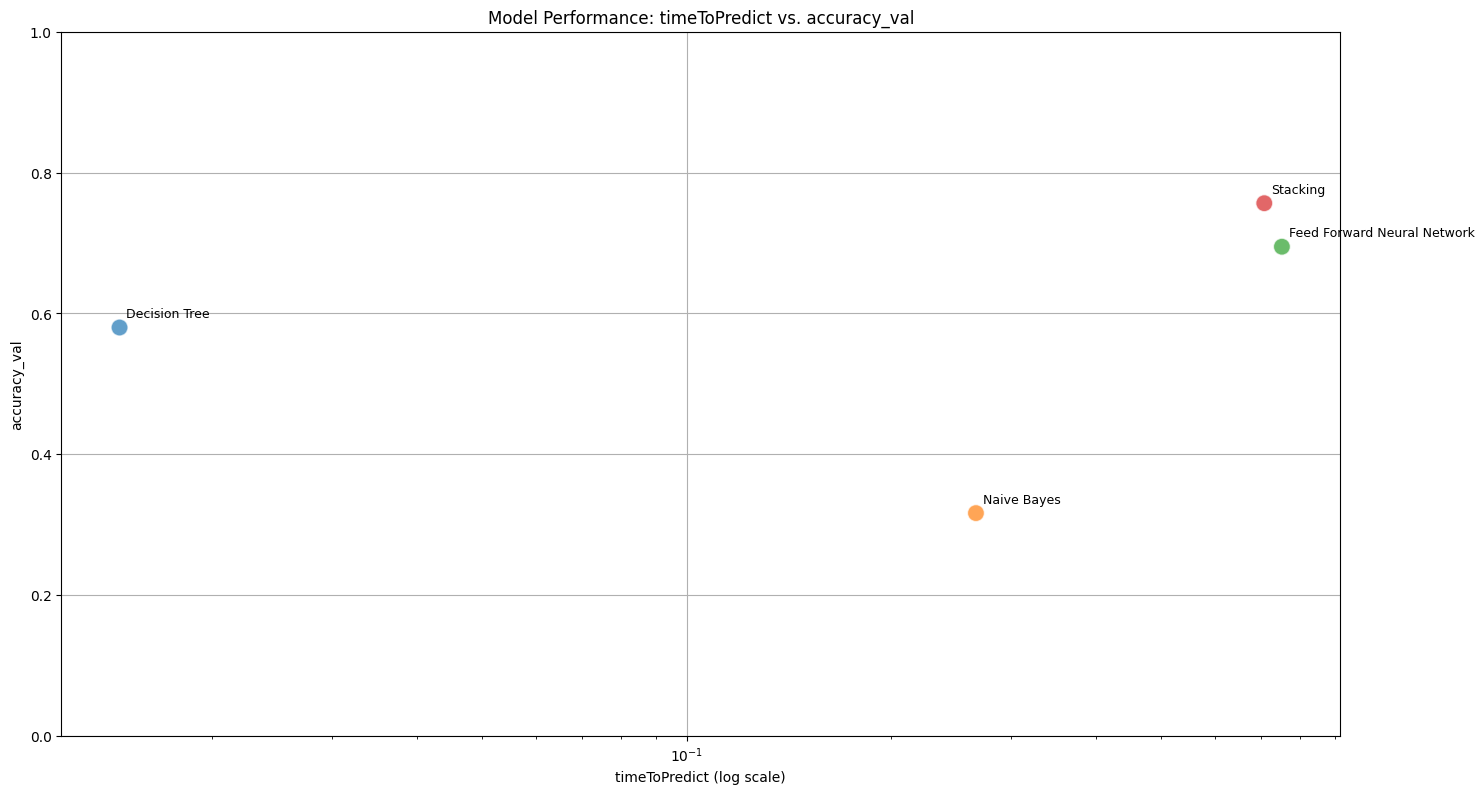

In [91]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToPredict", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (in-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

** EVALUATE HERE THE NOT OPTIMIZED VERSION TOO **

There going to be 4 rows and 4 columns


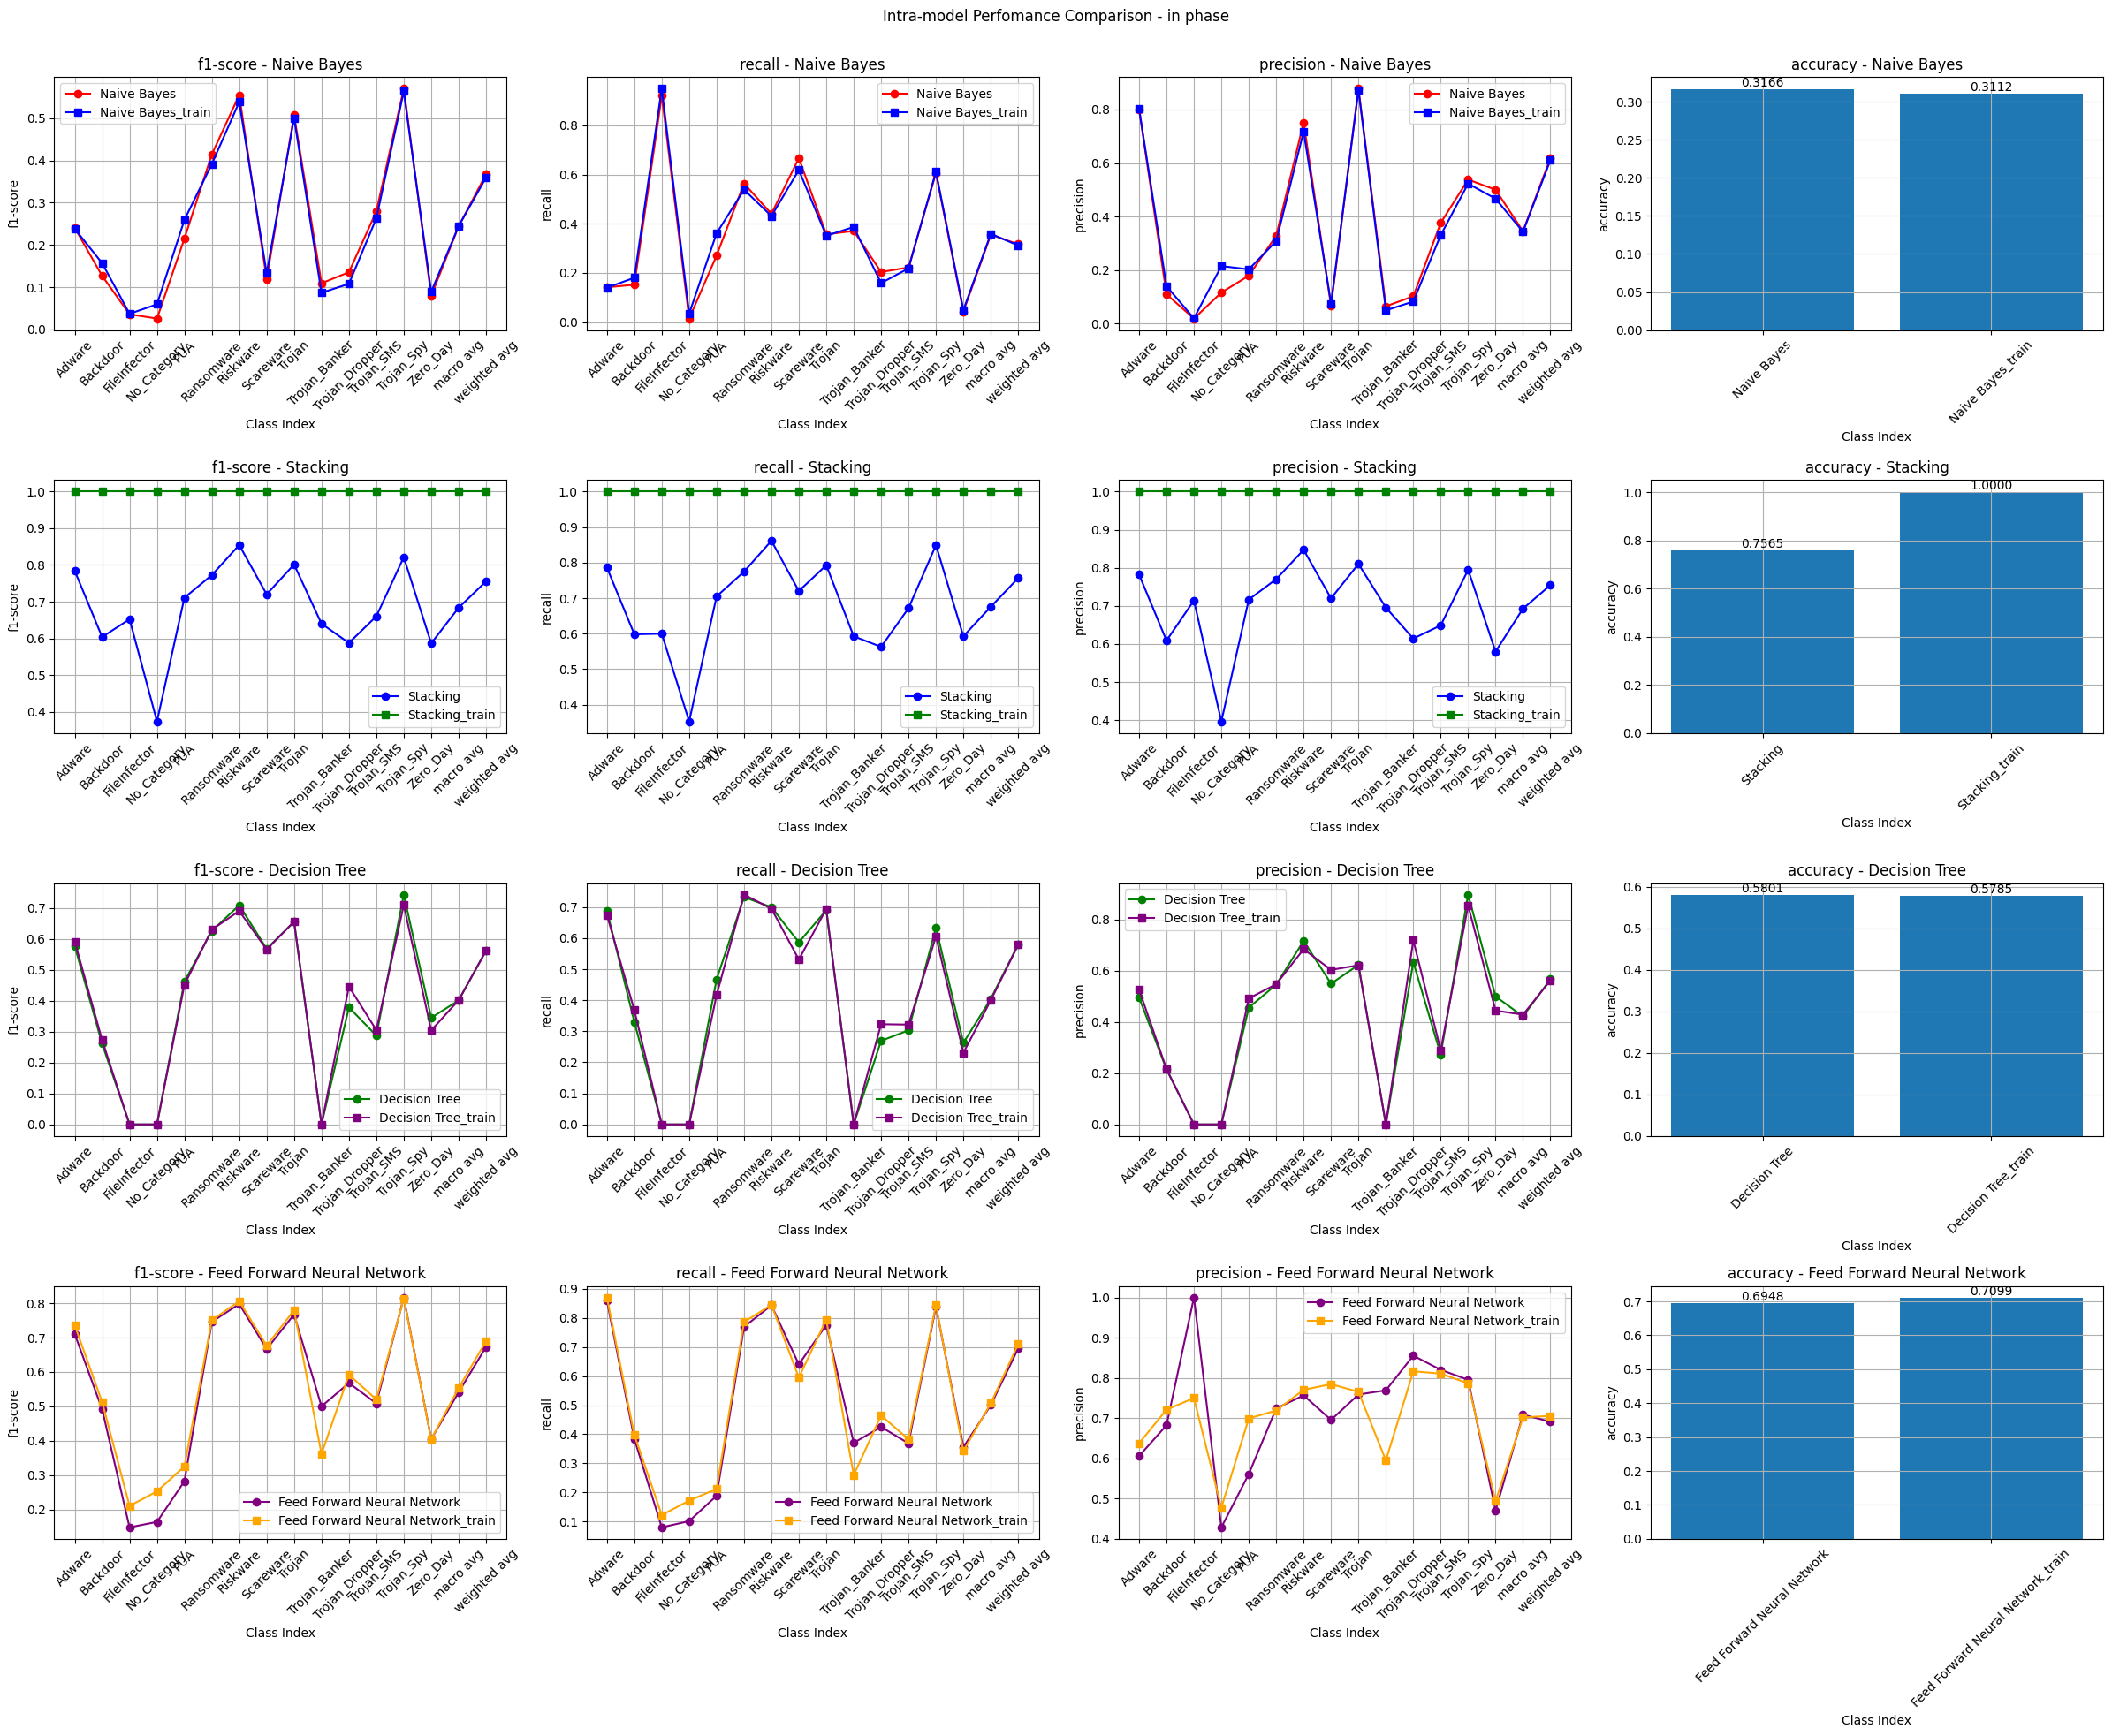

In [92]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

Unfortunately, keras does not store the per-epoch data when doing Bayesian hyperparemter optimization

In [93]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"])

### Residual analysis (in-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Naive Bayes
Plotting: Feed Forward Neural Network
Plotting: Stacking


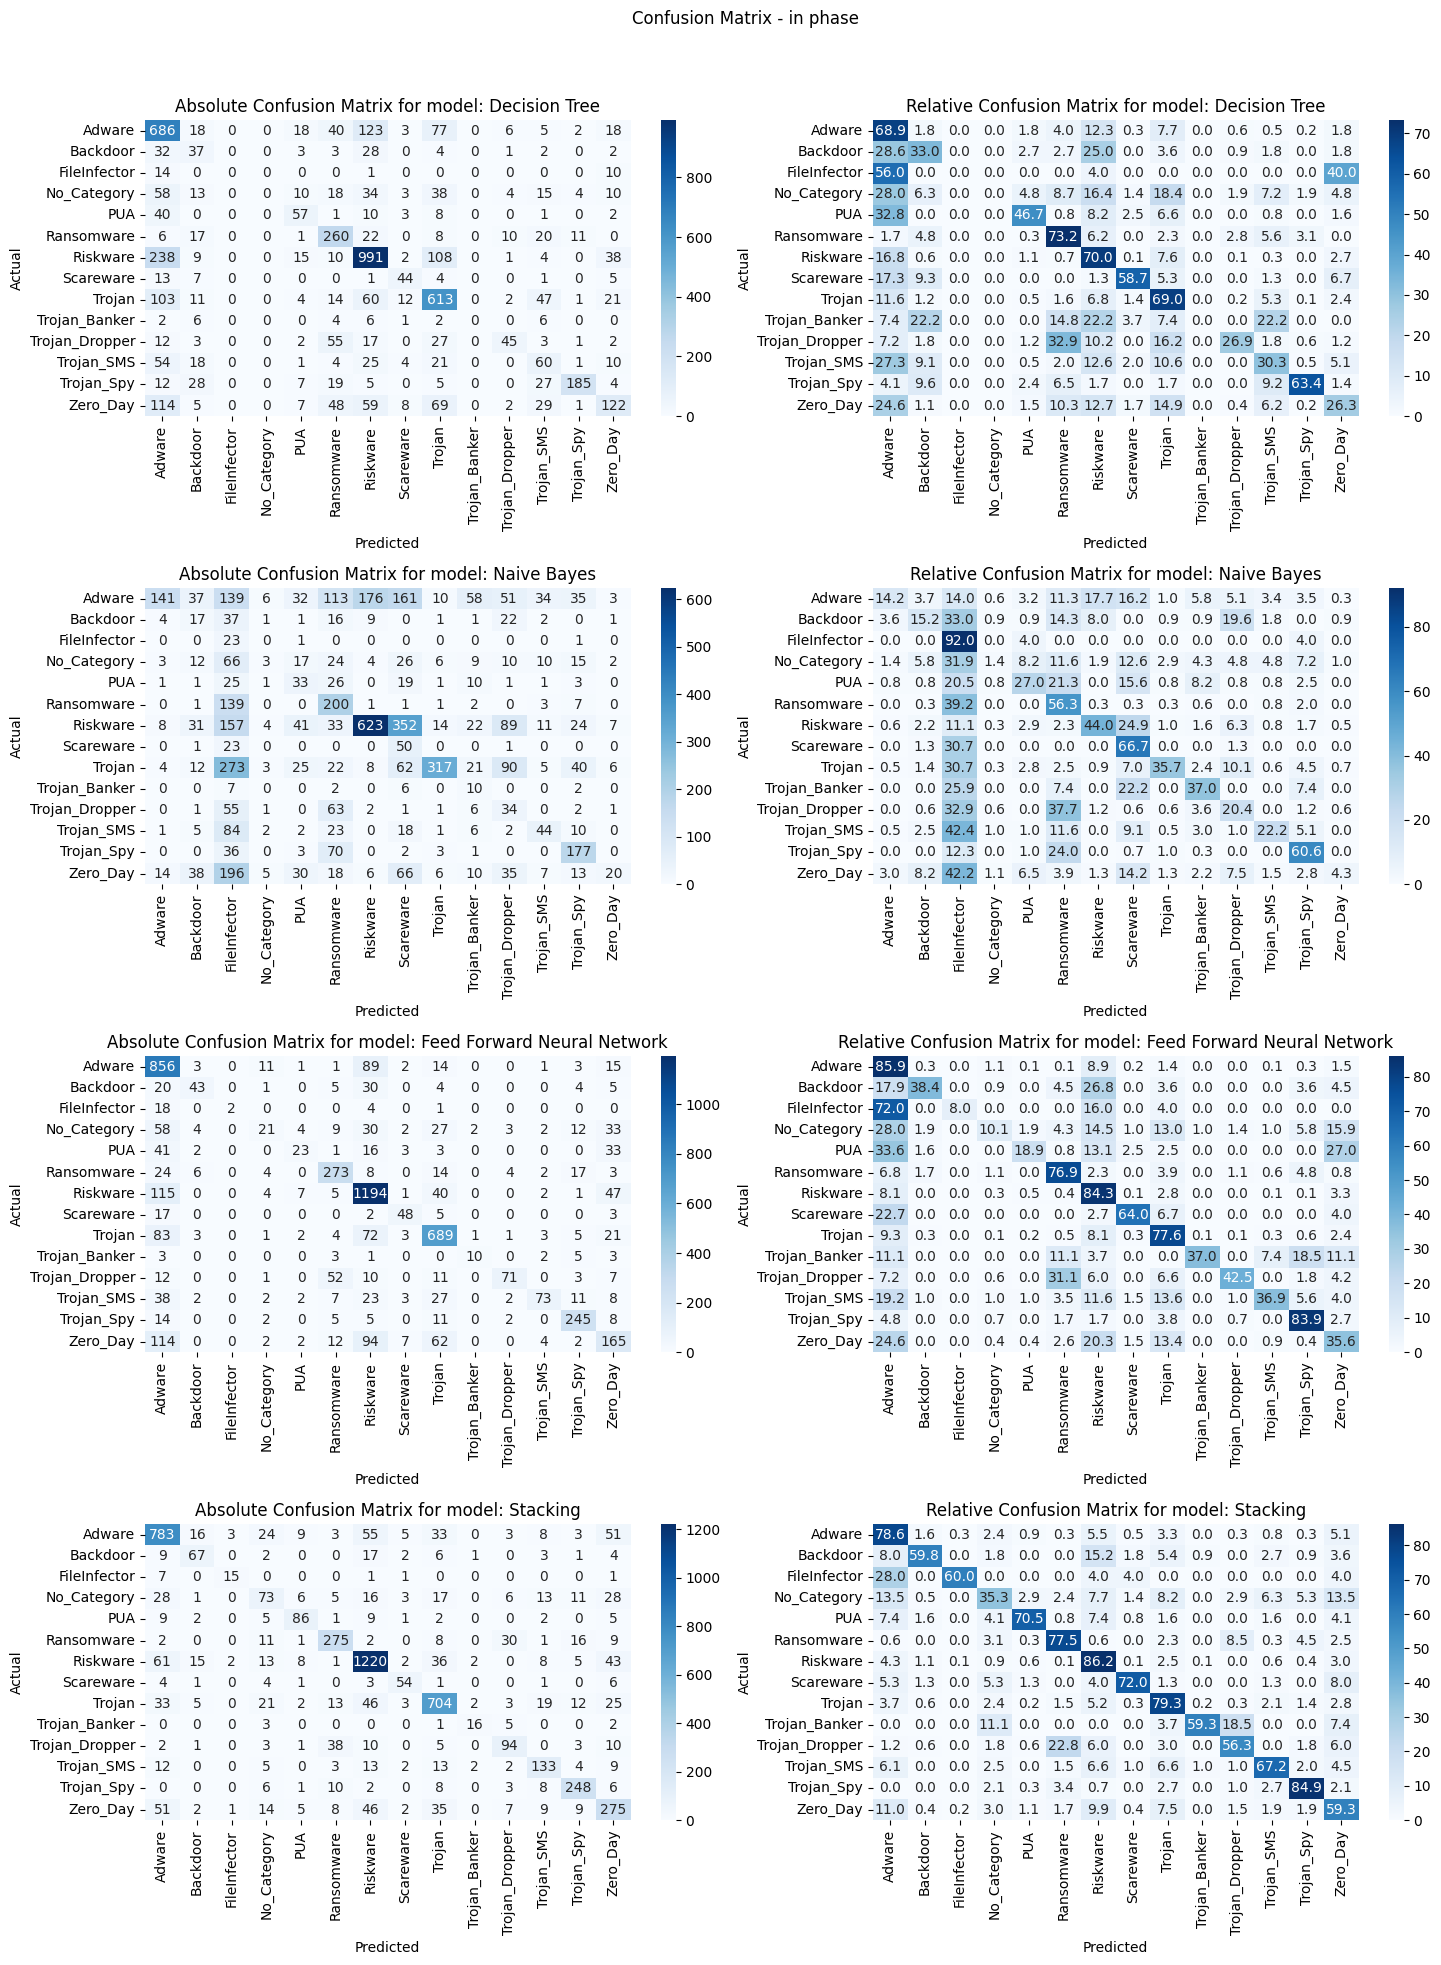

{'tree_based': 32688     8
 42208    12
 46651     8
 3727      0
 13497     3
          ..
 48766     5
 19939     6
 33882     3
 33656     3
 38099     6
 Length: 2244, dtype: int64,
 'naive_bayes': 8718     0
 5961     0
 32688    8
 46651    8
 3727     0
         ..
 19939    6
 33882    3
 20920    6
 32607    8
 38099    6
 Length: 3652, dtype: int64,
 'feed_forward_neural_network': 32688     8
 46651     8
 13497     3
 24902    13
 27555    13
          ..
 30190     8
 19939     6
 33882     3
 33656     3
 38099     6
 Length: 1631, dtype: int64,
 'stacking': 32688     8
 42208    12
 46651     8
 13497     3
 37307     6
          ..
 35718     6
 29263     8
 36945     6
 14009     5
 38099     6
 Length: 1301, dtype: int64}

In [94]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (in-tuning)

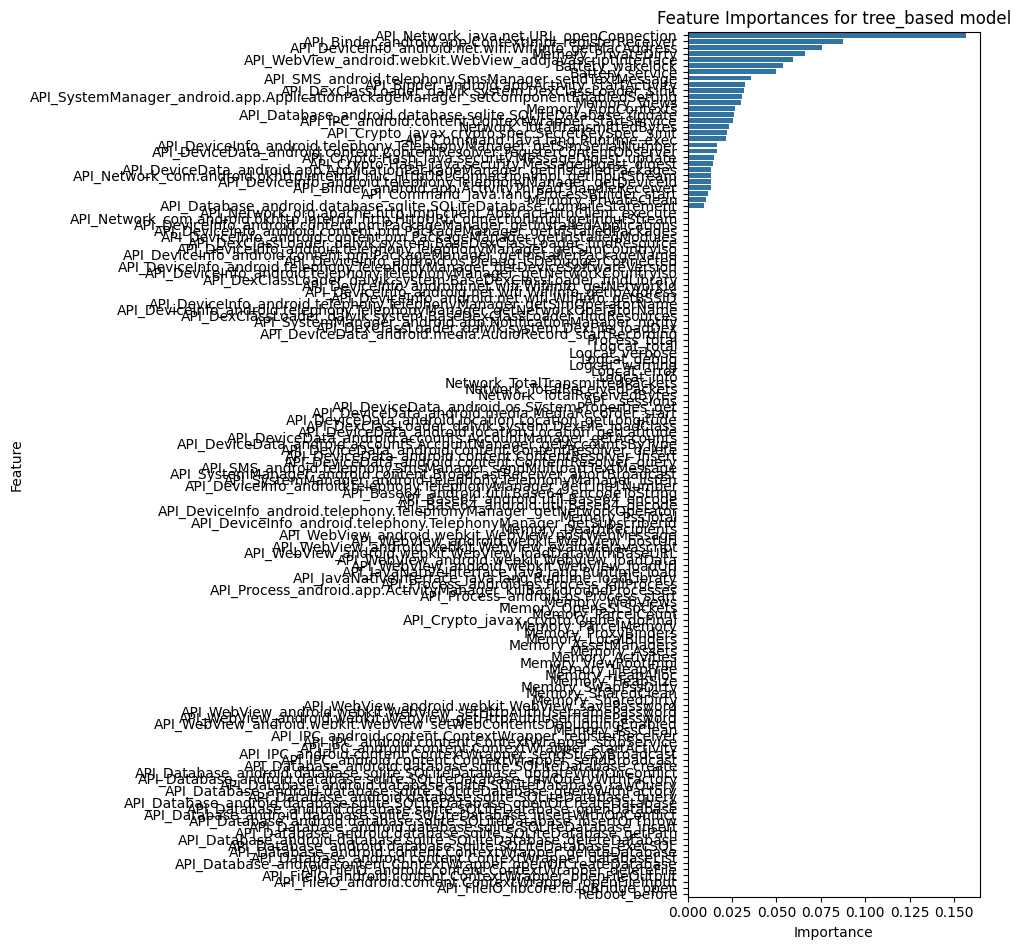

{'tree_based':                                                Feature  Importance
 96             API_Network_java.net.URL_openConnection    0.156866
 70   API_Binder_android.app.ContextImpl_registerRec...    0.087477
 83   API_DeviceInfo_android.net.wifi.WifiInfo_getMa...    0.075514
 3                                  Memory_PrivateDirty    0.066357
 33   API_WebView_android.webkit.WebView_addJavascri...    0.059125
 ..                                                 ...         ...
 44   API_FileIO_android.content.ContextWrapper_dele...    0.000000
 43   API_FileIO_android.content.ContextWrapper_open...    0.000000
 42   API_FileIO_android.content.ContextWrapper_open...    0.000000
 41                 API_FileIO_libcore.io.IoBridge_open    0.000000
 141                                      Reboot_before    0.000000
 
 [142 rows x 2 columns]}

In [95]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance(save_plots=False, save_path="")
importances_dfs

## Optimizer Covergance
Before we proceed, note that you can access the optimizser object (grid, random or bayes) as per shown in the following example. You may see more detailed information on the tuning process there. For now, we limit ourselves to solely plot the convergence map of the bayes optimizer

Questions:
- what can further be analyzed from this process in order to get better insights?

In [96]:
pipeline_manager.pipelines["not_baseline"]["ensembled"].modelling.list_of_models["Random Forest"].tuning_states["in"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Random Forest',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [97]:
#pipeline_manager.all_pipelines_execute(methodName="modelling.plot_convergence")

In [98]:
pipeline_manager.pipelines["baseline"]["baselines"].modelling.list_of_models["Majority Class (baseline)"].tuning_states["post"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [99]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment # just an example


{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                          num_classes=14, num_features=142)}

# Post-tuning Evaluation
Lets start off by selecting the best perfoming model

In [100]:
best_model, best_score = pipeline_manager.select_best_performing_model(metric="f1-score")

METRICS ARE: Index(['precision', 'recall', 'f1-score', 'support', 'accuracy', 'precision',
       'recall', 'f1-score', 'support', 'accuracy', 'precision', 'recall',
       'f1-score', 'support', 'accuracy', 'precision', 'recall', 'f1-score',
       'support', 'accuracy', 'precision', 'recall', 'f1-score', 'support',
       'accuracy', 'precision', 'recall', 'f1-score', 'support', 'accuracy',
       'precision', 'recall', 'f1-score', 'support', 'accuracy', 'precision',
       'recall', 'f1-score', 'support', 'accuracy'],
      dtype='object')
Merged report per phase is:                     precision         recall       f1-score        support  \
Adware               0.495665       0.688755       0.576471          996.0   
Backdoor             0.215116       0.330357       0.260563          112.0   
FileInfector              0.0            0.0            0.0           25.0   
No_Category               0.0            0.0            0.0          207.0   
PUA                     0.456    

In [101]:
pipeline_manager.fit_final_models()

Gonna start fitting models in post phase
=> Fitting Stacking model
Sklearn model: StackingClassifier(cv='prefit',
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Naive Bayes', GaussianNB()),
                               ('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                                                         num_classes=14,
                                                         num_features=142))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)
!> Started fitting Stacking
X_train_combined: (48095, 142)
Lenght of X_data: 48095


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


1503/1503 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
		 => Fitted Stacking. Took 1.1141068935394287 seconds
=> Predicting Stacking model
!> Started predicting Stacking


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


1503/1503 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
		 => Predicted Stacking. Took 0.8132357597351074 seconds
Fitted and predicted model Stacking
Gonna start fitting models in post phase
=> Fitting Majority Class (baseline) model
Sklearn model: <library.utils.ownModels.majorityClassModel.MajorityClassClassifier object at 0x2958ef790>
!> Started fitting Majority Class (baseline)
X_train_combined: (48095, 142)
Lenght of X_data: 48095
		 => Fitted Majority Class (baseline). Took 0.013792037963867188 seconds
=> Predicting Majority Class (baseline) model
!> Started predicting Majority Class (baseline)
		 => Predicted Majority Class (baseline). Took 4.291534423828125e-05 seconds
Fitted and predicted model Majority Class (baseline)


In [102]:
pipeline_manager.evaluate_store_final_models()

Evaluating model Stacking
Evaluating Stacking in post phase
METRIC RESULTS FOR Stacking => F1: 0.7468499006524882, Precision: 0.7463888487279486, Recall: 0.7481287425149701, Accuracy: 0.7481287425149701
All models have been evaluated.
Evaluating model Majority Class (baseline)
Evaluating Majority Class (baseline) in post phase
METRIC RESULTS FOR Majority Class (baseline) => F1: 0.10380044919106332, Precision: 0.0651472130589121, Recall: 0.25523952095808383, Accuracy: 0.25523952095808383


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': 'ab84c38d9fcb87b0d040dca5ccfc4f4bc586b18b878d5d906c2ea8bd7e51038c', 'timeStamp': '2025-05-03 13:38:19', 'comments': 'I know cate will not like this comment', 'modelName': 'Majority Class (baseline)', 'currentPhase': 'post', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.Activi

### Metric Evaluation

In [103]:
pipeline_manager.pipeline_state = "post"

### Cross-Model Evaluation (post-tuning)

In [104]:
class_report_df = pipeline_manager.pipelines_analysis._compute_classification_report(include_training=True)
class_report_df

precision    recall  f1-score   support  accuracy  \
Adware          0.804067   0.77957  0.791629    1116.0  0.748129   
Backdoor        0.614754  0.652174  0.632911     115.0  0.748129   
FileInfector    0.727273  0.592593  0.653061      27.0  0.748129   
No_Category     0.390863  0.407407  0.398964     189.0  0.748129   
PUA             0.703125  0.714286  0.708661     126.0  0.748129   
Ransomware          0.74      0.74      0.74     350.0  0.748129   
Riskware        0.826025  0.856305  0.840893    1364.0  0.748129   
Scareware       0.729412  0.704545  0.716763      88.0  0.748129   
Trojan          0.793802  0.822222  0.807762     810.0  0.748129   
Trojan_Banker   0.590909  0.393939  0.472727      33.0  0.748129   
Trojan_Dropper      0.55  0.526946  0.538226     167.0  0.748129   
Trojan_SMS      0.682051  0.639423   0.66005     208.0  0.748129   
Trojan_Spy      0.817869  0.832168  0.824957     286.0  0.748129   
Zero_Day        0.556064  0.522581  0.538803     465.0  0.748129   
macro avg       0.680444  0.656011  0.666101    5344.0  0.748129   
weighted avg    0.746389  0.748129   0.74685    5344.0  0.748129   
modelName       Stacking  Stacking  Stacking  Stacking  Stacking   

                     precision          recall        f1-score  \
Adware                0.920146        0.909455        0.914769   
Backdoor              0.891707        0.891707        0.891707   
FileInfector          0.886878        0.878924        0.882883   
No_Category           0.886912        0.895652         0.89126   
PUA                   0.901809        0.896404        0.899098   
Ransomware            0.893534        0.895288         0.89441   
Riskware              0.916391        0.920234        0.918309   
Scareware             0.908521        0.893958        0.901181   
Trojan                0.902976        0.912306        0.907617   
Trojan_Banker         0.870192        0.845794         0.85782   
Trojan_Dropper        0.885164        0.884533        0.884848   
Trojan_SMS            0.891392        0.886272        0.888825   
Trojan_Spy            0.892675        0.894427         0.89355   
Zero_Day              0.894435        0.893543        0.893989   
macro avg             0.895909         0.89275        0.894305   
weighted avg          0.906296        0.906269        0.906268   
modelName       Stacking_train  Stacking_train  Stacking_train   

                       support        accuracy                  precision  \
Adware                  9984.0        0.906269                        0.0   
Backdoor                1025.0        0.906269                        0.0   
FileInfector             223.0        0.906269                        0.0   
No_Category             1725.0        0.906269                        0.0   
PUA                     1168.0        0.906269                        0.0   
Ransomware              3056.0        0.906269                        0.0   
Riskware               12637.0        0.906269                    0.25524   
Scareware                811.0        0.906269                        0.0   
Trojan                  7549.0        0.906269                        0.0   
Trojan_Banker            214.0        0.906269                        0.0   
Trojan_Dropper          1403.0        0.906269                        0.0   
Trojan_SMS              1741.0        0.906269                        0.0   
Trojan_Spy              2548.0        0.906269                        0.0   
Zero_Day                4011.0        0.906269                        0.0   
macro avg              48095.0        0.906269                   0.018231   
weighted avg           48095.0        0.906269                   0.065147   
modelName       Stacking_train  Stacking_train  Majority Class (baseline)   

                                   recall                   f1-score  \
Adware                                0.0                        0.0   
Backdoor                              0.0                        0.0  

PLOTTING CROSS MODEL COMPARISON FOR post PHASE
There going to be 2 rows and 2 columns
Plotting: f1-score
Plotting: recall
Plotting: precision
Plotting: accuracy


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


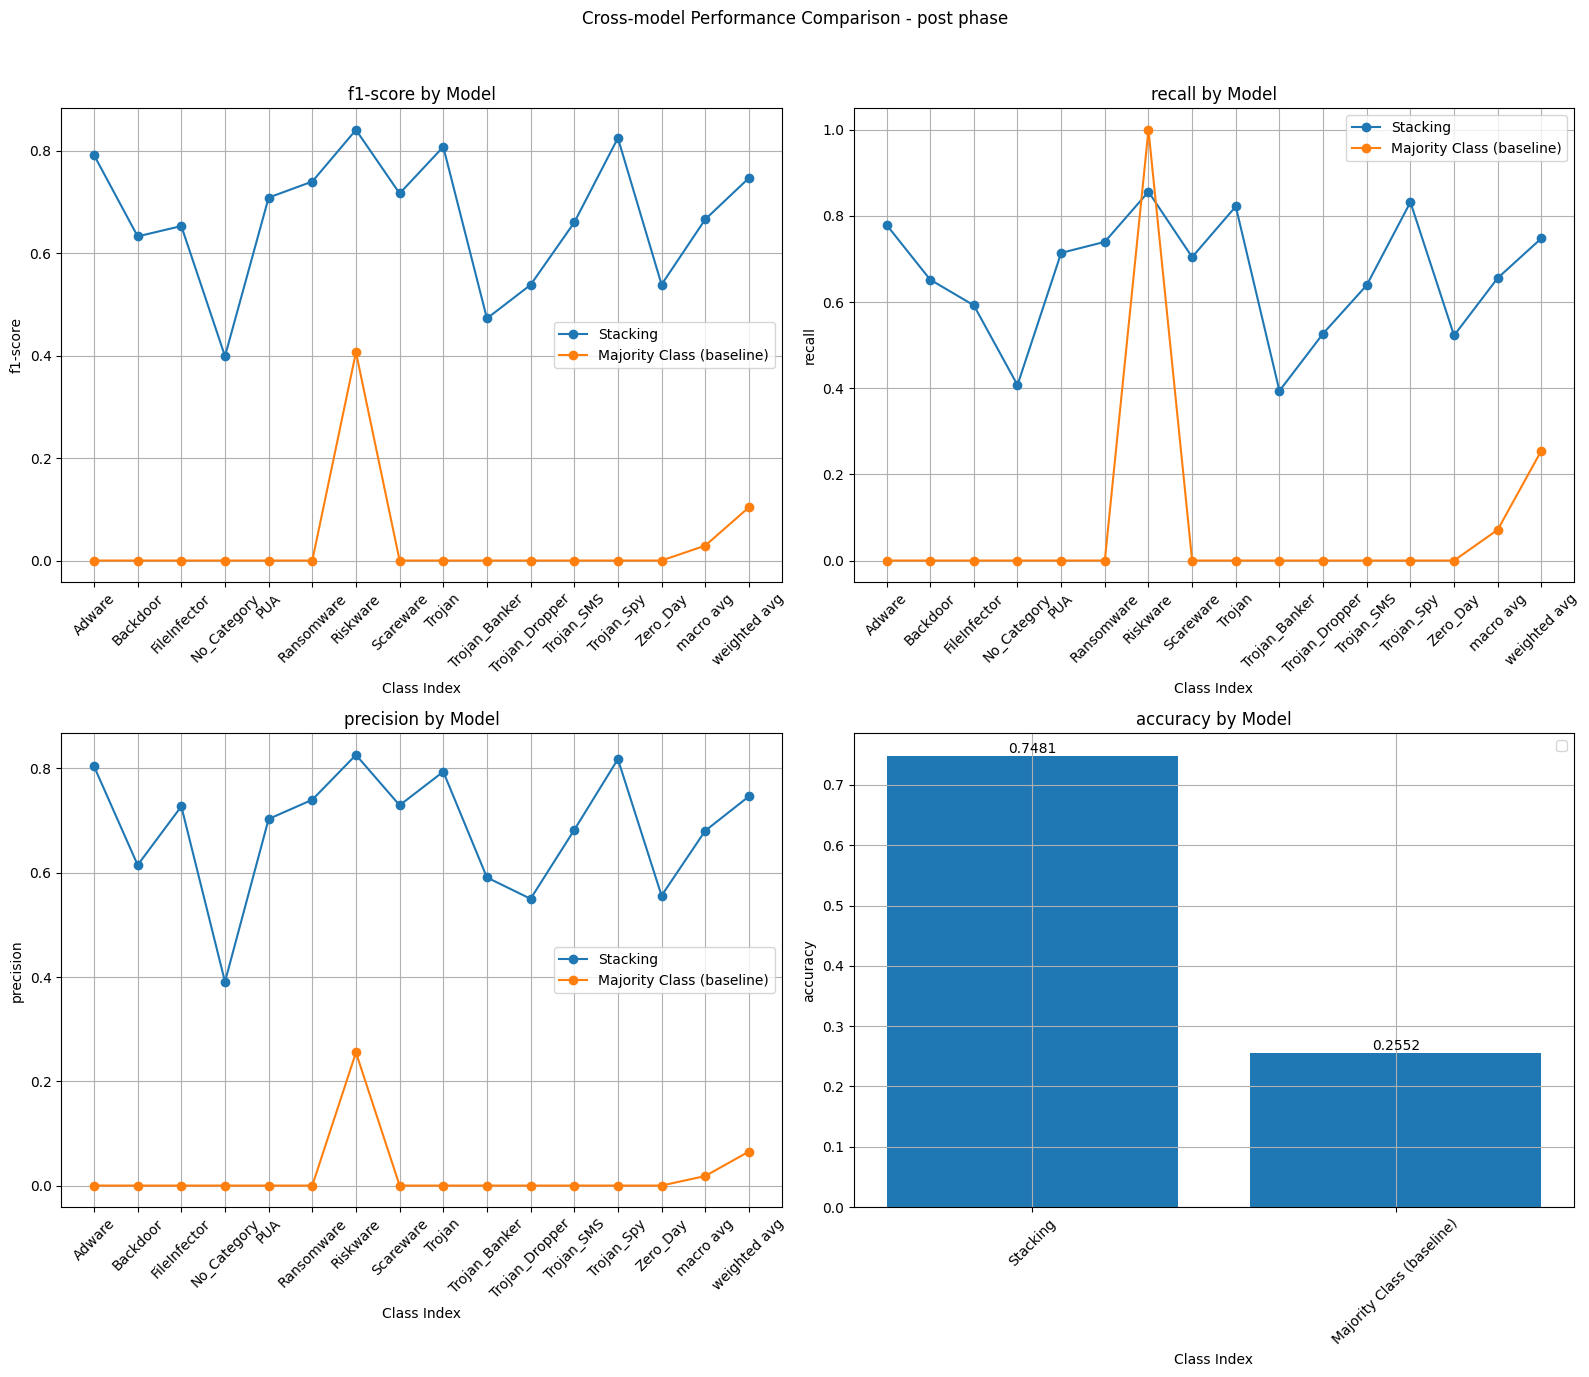

In [105]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  6e6ae6cc787eb4cc3cb19ad82a5c974f9803c917da47b0...  2025-05-03 13:38:14   

                                 comments modelName currentPhase  \
0  I know cate will not like this comment  Stacking         post   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'cv': 'prefit', 'estimators': [('Decision Tre...   1.114107   

   timeToPredict classification_report  accuracy_test  accuracy_val  \
0       0.813236                  None       0.748129            -1   

   precision_test  precision_val  recall_test  recall_val  f1-score_test  \
0        0.746389             -1     0.748129          -1        0.74685   

   f1-score_val  
0            -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


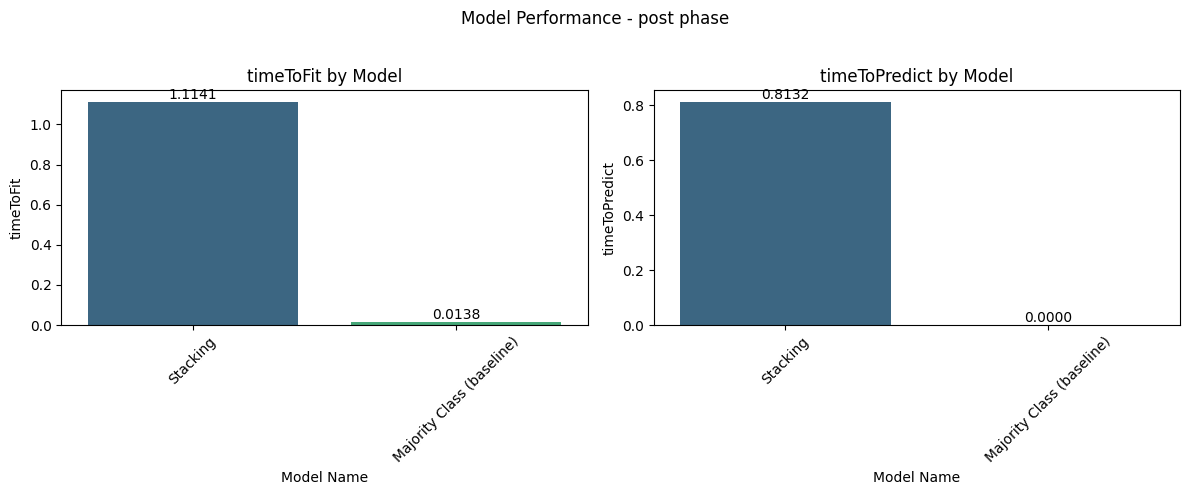

id            timeStamp  \
0  6e6ae6cc787eb4cc3cb19ad82a5c974f9803c917da47b0...  2025-05-03 13:38:14   
0  ab84c38d9fcb87b0d040dca5ccfc4f4bc586b18b878d5d...  2025-05-03 13:38:19   

                                 comments                  modelName  \
0  I know cate will not like this comment                   Stacking   
0  I know cate will not like this comment  Majority Class (baseline)   

  currentPhase                                      features_used  \
0         post  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0         post  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'cv': 'prefit', 'estimators': [('Decision Tre...   1.114107   
0                                                 {}   0.013792   

   timeToPredict classification_report  accuracy_test  accuracy_val  \
0       0.813236                  None       0.748129            -1   
0       0.000043                  None       0.255240            -1   

   precision_test  precision_val  recall_test  recall_val  f1-score_test  \
0        0.746389             -1     0.748129          -1        0.74685   
0        0.065147             -1     0.255240          -1        0.10380   

   f1-score_val  
0            -1  
0            -1

In [106]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")

### Results Summary Visualization

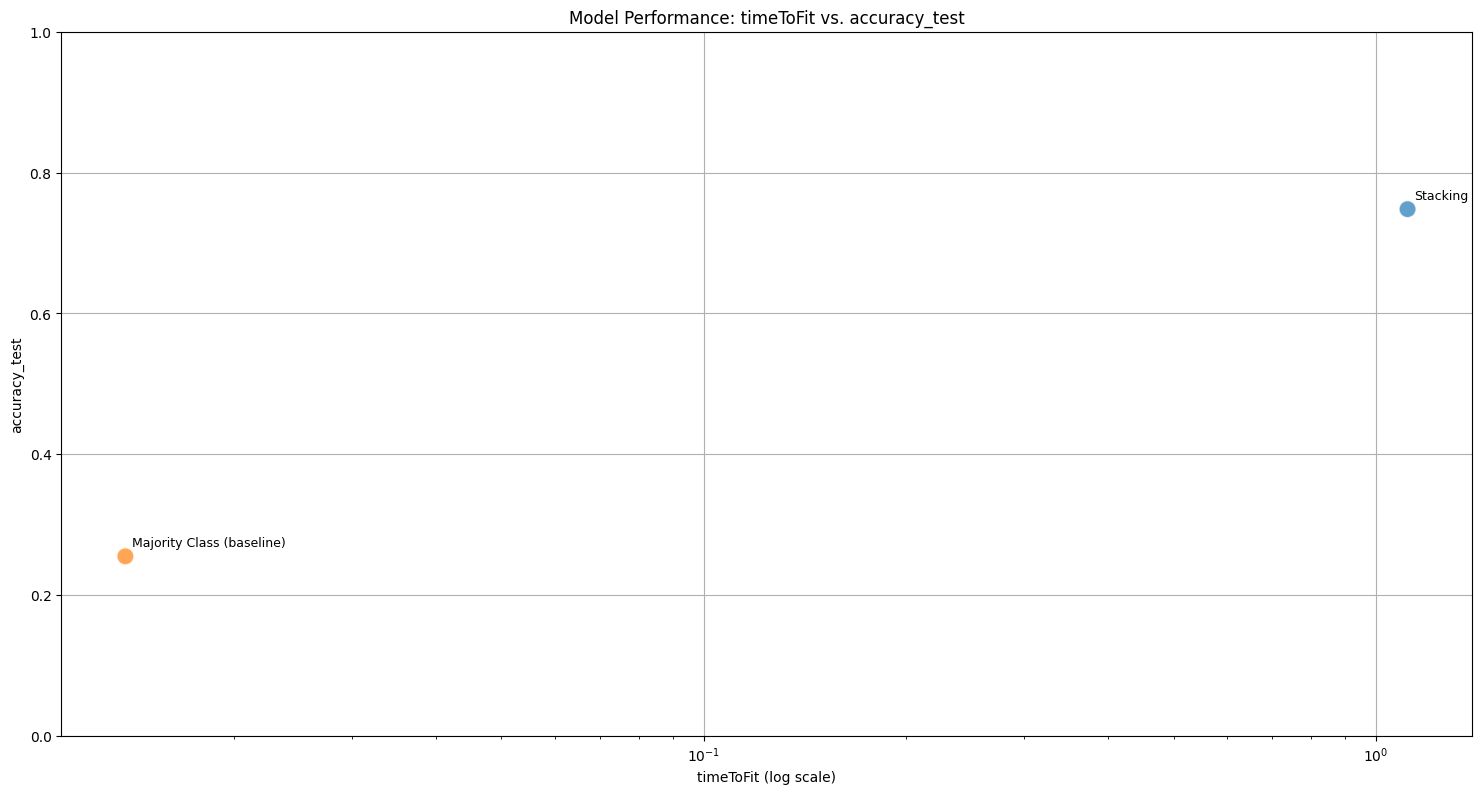

In [107]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (post-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

There going to be 2 rows and 3 columns


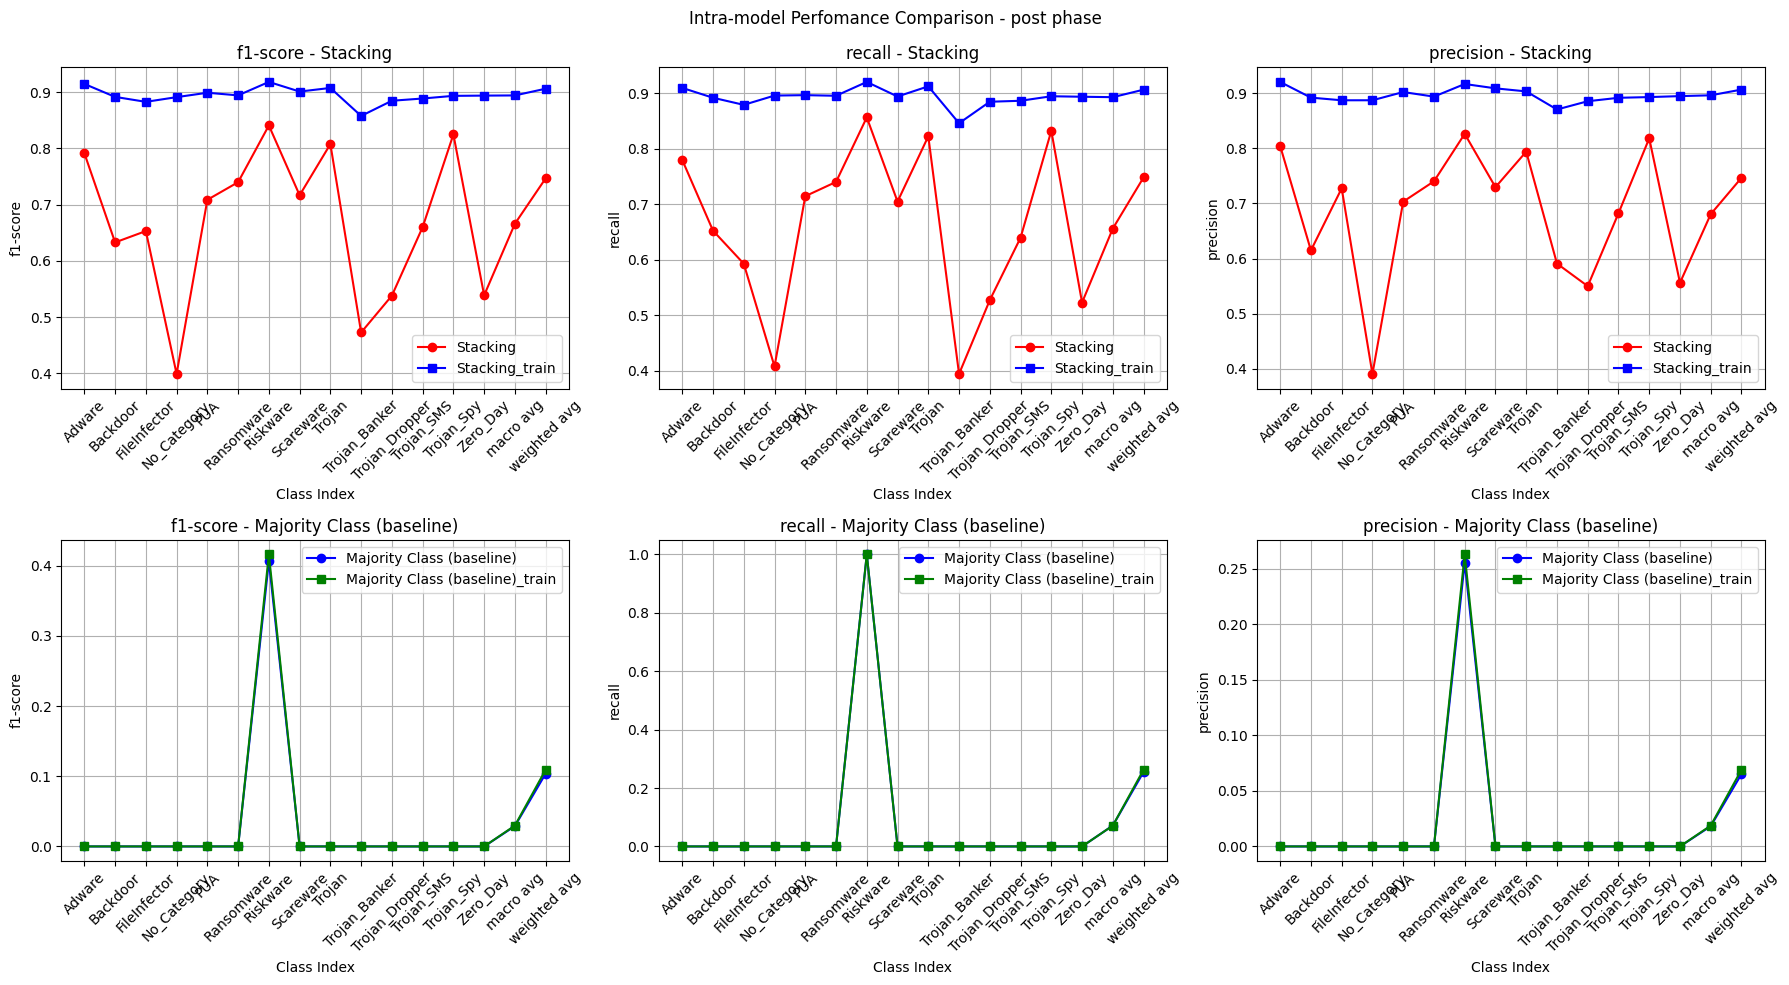

In [108]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"], save_plots=False, save_path="")


Lets see the progress of the NN

In [109]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"])

### Residual analysis (post-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Stacking
Plotting: Majority Class (baseline)


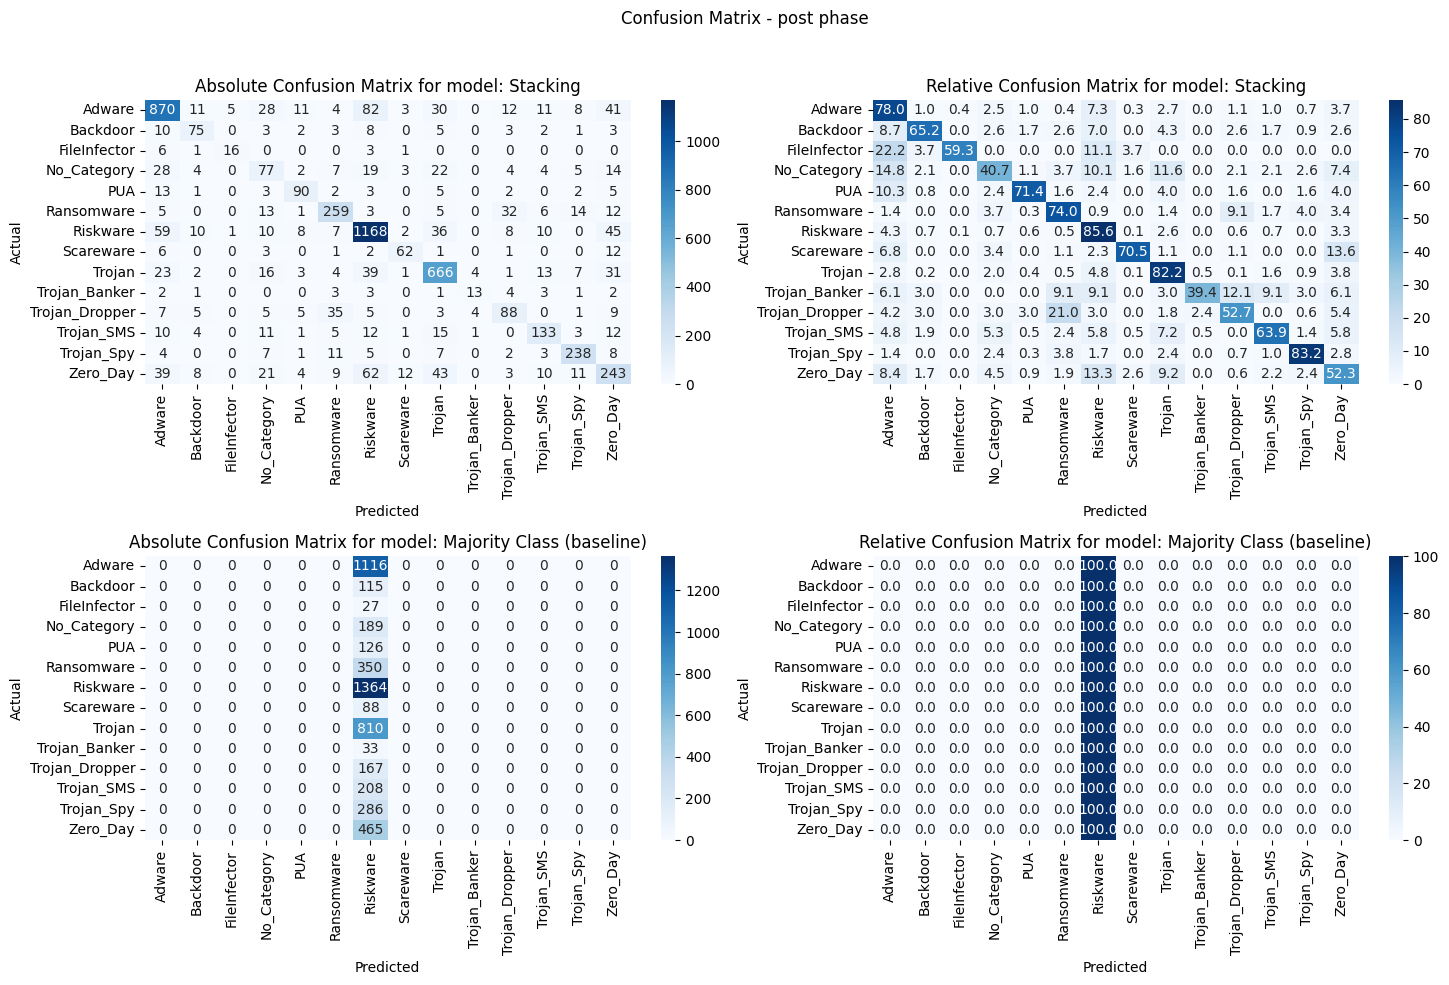

{'stacking': 28550    13
 8287      0
 33765     3
 47614     8
 33487     3
          ..
 41688    11
 13445     3
 42115    12
 53065     4
 49176     5
 Length: 1346, dtype: int64,
 'baselines': 28550    13
 43091    12
 8287      0
 47969     8
 29839     8
          ..
 53065     4
 49176     5
 30395     8
 4491      0
 2304      0
 Length: 3980, dtype: int64}

In [110]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (post-tuning)

In [111]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance(save_plots=False, save_path="")
importances_dfs

{}

In [112]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].assesment["model_sklearn"].estimators_

[DecisionTreeClassifier(),
 GaussianNB(),
 FeedForwardNeuralNetwork(model_keras=<Sequential name=sequential, built=True>,
                          num_classes=14, num_features=142)]

## Saving Best Model

In [113]:
#pipeline_manager.serialize_models(models_to_serialize=["Majority Class (baseline)"])

In [114]:
#pipeline_manager.serialize_pipelines(pipelines_to_serialize=["naive-bayes"])